# **Demand Forecasting Optimization for Corporation Favorita A Time Series Regression ML Approach**

### Table of Contents
1. [Business Understanding](#business-understanding)
2. [Data collection](#Data-collection)
3. [Data Cleaning](#Data-Cleaning)
4. [Exploratory Data Analysis (EDA)](#exploratory-data-analysis-(EDA))
5. [Hypotheses Testing](#Hypotheses-Testing)
6. [Analytical Questions](#analytical-questions)


## **Business Understanding**

Corporation Favorita, a large grocery retailer based in Ecuador, aims to optimize its inventory management to ensure the right quantity of products is always in stock across its various locations. Effective inventory management is critical for maintaining high levels of customer satisfaction and minimizing costs associated with overstocking or stockouts.

To achieve this goal, we will build machine learning models to forecast the demand for products at different Favorita stores. Accurate demand forecasting will allow Corporation Favorita to make informed decisions regarding stock levels, promotions, and supply chain logistics.

#### Objective:
1. **Develop Predictive Models**: Create models to forecast daily unit sales for thousands of products across multiple stores.
2. **Understand Influencing Factors**: Analyze the impact of various factors on sales, including promotions, holidays, oil prices, store characteristics, and external events such as earthquakes.
3. **Optimize Inventory Management**: Use the models to inform inventory decisions, ensuring that the right products are available at the right stores at the right time.

#### Hypothesis:
1. Null Hypothesis (H0): Promotions do not have a significant impact on sales.  
   Alternative Hypothesis (H1): Promotions have a significant impact on sales.
2. Null Hypothesis (H0): Oil prices do not significantly impact sales.  
   Alternative Hypothesis (H1): Oil prices significantly impact sales.

#### Key Analytical Questions:
1. **Data Completeness**: Is the training dataset complete with all required dates?
2. **Sales Extremes**: Which dates have the lowest and highest sales for each year (excluding days when stores were closed)?
3. **Monthly Sales Trends**: Compare sales across months and years to identify the highest sales month and year.
4. **Earthquake Impact**: Did the earthquake in April 2016 impact sales?
5. **Store Performance**: Are certain stores or groups of stores (cluster, city, state, type) selling more products?
6. **Promotions, Oil Prices, and Holidays**: How are sales affected by promotions, oil prices, and holidays?
7. **Date Features Analysis**: What insights can be derived from date-related features?
8. **Promotion Impact**: Which product families and stores were most affected by promotions?
9. **Error Metrics**: What is the difference between RMSLE, RMSE, and MSE? Why might MAE be greater than these metrics?
10. **Wage Payment Influence**: Does the bi-monthly payment of public sector wages influence store sales?


#### Data Sources
- **train.csv**: Time series data of store, product information, promotions, and sales.
- **test.csv**: Features similar to the training data for the 15 days following the last date in the training data.
- **transaction.csv**: Daily transactions per store.
- **stores.csv**: Metadata about stores including location and type.
- **oil.csv**: Daily oil prices.
- **holidays_events.csv**: Information about holidays and events, including special designations like transferred, bridge, and work days.
- **sample_submission.csv**: A sample submission file for formatting predictions.


## **Importing Necessary packages**

In [1]:
import pyodbc
from dotenv import dotenv_values
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import FuncFormatter
from scipy.stats import ttest_ind
import statsmodels.api as sm
import matplotlib.ticker as ticker
from statsmodels.tsa.stattools import adfuller
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from xgboost import XGBRegressor
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, Ridge
import matplotlib as mpl
import joblib


import warnings
warnings.filterwarnings('ignore')


# Seaborn color palette
palette = sns.color_palette("tab10")

# Function to format y-axis labels in millions
def millions(x, pos):
    return '%1.0fM' % (x * 1e-6)

## **Data Collection**

In [2]:
# Loading environment variables from .env file
environment_variables = dotenv_values('.env')

# Getting the values for the credentials set in the .env file
server = environment_variables.get("SERVER")
database = environment_variables.get("DATABASE")
username = environment_variables.get("USERNAME")
password = environment_variables.get("PASSWORD")

# Creating a connection string
connection_string = f"DRIVER={{SQL Server}}; \
                    SERVER={server}; \
                    DATABASE={database}; \
                    UID={username}; \
                    PWD={password};"

# Connecting to the server
connection = pyodbc.connect(connection_string)

Loading data from the database

In [3]:
# Loading Oil dataset
oil = pd.read_sql_query("SELECT * FROM dbo.oil", connection)

# Saving the DataFrame to a CSV file
oil.to_csv('data/oil.csv', index=False)

oil.head()

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.139999
2,2013-01-03,92.970001
3,2013-01-04,93.120003
4,2013-01-07,93.199997


In [4]:
# Loading holidays_events dataset
holidays_events = pd.read_sql_query(
    "SELECT * FROM dbo.holidays_events", connection)

# Saving the DataFrame to a CSV file
holidays_events.to_csv('data/holidays_events.csv', index=False)

holidays_events.head()

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


In [5]:
# Loading stores dataset
stores = pd.read_sql_query("SELECT * FROM dbo.stores", connection)

# Saving the DataFrame to a CSV file
stores.to_csv('data/stores.csv', index=False)

stores.head()

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


In [6]:
train = pd.read_csv('Data/train.csv')

train.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [7]:
test = pd.read_csv('Data/test.csv')

test.head()

,id,date,store_nbr,family,onpromotion
0,3000888,2017-08-16,1,AUTOMOTIVE,0
1,3000889,2017-08-16,1,BABY CARE,0
2,3000890,2017-08-16,1,BEAUTY,2
3,3000891,2017-08-16,1,BEVERAGES,20
4,3000892,2017-08-16,1,BOOKS,0


In [8]:
transactions = pd.read_csv('Data/transactions.csv')

transactions.head()

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


In [9]:
sample_submission = pd.read_csv('Data/sample_submission.csv')

sample_submission.head()

,id,sales
0,3000888,0.0
1,3000889,0.0
2,3000890,0.0
3,3000891,0.0
4,3000892,0.0


## **Data Cleaning**

1. Missing Values Handling

In [10]:
# Checking for missing values in each dataset
missing_values_train = train.isnull().sum()
missing_values_test = test.isnull().sum()
missing_values_transactions = transactions.isnull().sum()
missing_values_stores = stores.isnull().sum()
missing_values_oil = oil.isnull().sum()
missing_values_holidays_events = holidays_events.isnull().sum()
missing_values_sample_submission = sample_submission.isnull().sum()

missing_values_train, missing_values_test, missing_values_transactions, missing_values_stores, missing_values_oil, missing_values_holidays_events, missing_values_sample_submission

(id             0
 date           0
 store_nbr      0
 family         0
 sales          0
 onpromotion    0
 dtype: int64,
 id             0
 date           0
 store_nbr      0
 family         0
 onpromotion    0
 dtype: int64,
 date            0
 store_nbr       0
 transactions    0
 dtype: int64,
 store_nbr    0
 city         0
 state        0
 type         0
 cluster      0
 dtype: int64,
 date           0
 dcoilwtico    43
 dtype: int64,
 date           0
 type           0
 locale         0
 locale_name    0
 description    0
 transferred    0
 dtype: int64,
 id       0
 sales    0
 dtype: int64)

In [11]:
# Filling missing values in the oil dataset using forward fill
oil['dcoilwtico'].fillna(method='ffill', inplace=True)

# Verifying that there are no more missing values
missing_values_oil = oil.isnull().sum()
missing_values_oil

date          0
dcoilwtico    1
dtype: int64

In [12]:
# Filling the remaining missing value using backward fill
oil['dcoilwtico'].fillna(method='bfill', inplace=True)

# Verifying that there are no more missing values
missing_values_oil = oil.isnull().sum()
missing_values_oil

date          0
dcoilwtico    0
dtype: int64

2. Data Types Correction

In [13]:
# Converting date columns to datetime format
train['date'] = pd.to_datetime(train['date'])
test['date'] = pd.to_datetime(test['date'])
transactions['date'] = pd.to_datetime(transactions['date'])
oil['date'] = pd.to_datetime(oil['date'])
holidays_events['date'] = pd.to_datetime(holidays_events['date'])

3. Merging Datasets

In [14]:
# Merging train dataset with transactions, stores, oil, and holidays_events
train_merged = train.merge(transactions, on=['date', 'store_nbr'], how='left')
train_merged = train_merged.merge(stores, on='store_nbr', how='left')
train_merged = train_merged.merge(oil, on='date', how='left')
train_merged = train_merged.merge(holidays_events, on='date', how='left')

# Repeating the same for the test dataset
test_merged = test.merge(transactions, on=['date', 'store_nbr'], how='left')
test_merged = test_merged.merge(stores, on='store_nbr', how='left')
test_merged = test_merged.merge(oil, on='date', how='left')
test_merged = test_merged.merge(holidays_events, on='date', how='left')

In [15]:
# necessary renames 
train_merged.rename(columns={'type_x': 'store_type','type_y': 'holiday_type'}, inplace=True)
test_merged.rename(columns={'type_x': 'store_type','type_y': 'holiday_type'}, inplace=True)

In [16]:
# Filling null values in transactions with 0
train_merged['transactions'].fillna(0, inplace=True)
test_merged['transactions'].fillna(0, inplace=True)

# Forward filling and backward filling for dcoilwtico
train_merged['dcoilwtico'].fillna(method='ffill', inplace=True)
train_merged['dcoilwtico'].fillna(method='bfill', inplace=True)

test_merged['dcoilwtico'].fillna(method='ffill', inplace=True)
test_merged['dcoilwtico'].fillna(method='bfill', inplace=True)

# Filling holiday-related columns with 'None'
holiday_related_cols = ['holiday_type', 'locale','locale_name', 'description', 'transferred']
train_merged[holiday_related_cols] = train_merged[holiday_related_cols].fillna('None')
test_merged[holiday_related_cols] = test_merged[holiday_related_cols].fillna('None')

4. Creating Date Features

In [17]:
# Create additional features from the date
train_merged['year'] = train_merged['date'].dt.year
train_merged['month'] = train_merged['date'].dt.month
train_merged['day'] = train_merged['date'].dt.day
train_merged['dayofweek'] = train_merged['date'].dt.dayofweek

test_merged['year'] = test_merged['date'].dt.year
test_merged['month'] = test_merged['date'].dt.month
test_merged['day'] = test_merged['date'].dt.day
test_merged['dayofweek'] = test_merged['date'].dt.dayofweek

## **Exploratory Data Analysis (EDA)**

In [18]:
# Grouping by date and sum sales to get the overall sales trend over time
sales_trend = train_merged.groupby('date')['sales'].sum().reset_index()

# Grouping by year and month for monthly trend
sales_trend['year_month'] = sales_trend['date'].dt.to_period('M')
monthly_sales_trend = sales_trend.groupby(
    'year_month')['sales'].sum().reset_index()

# Grouping by year for yearly trend
sales_trend['year'] = sales_trend['date'].dt.year
yearly_sales_trend = sales_trend.groupby('year')['sales'].sum().reset_index()

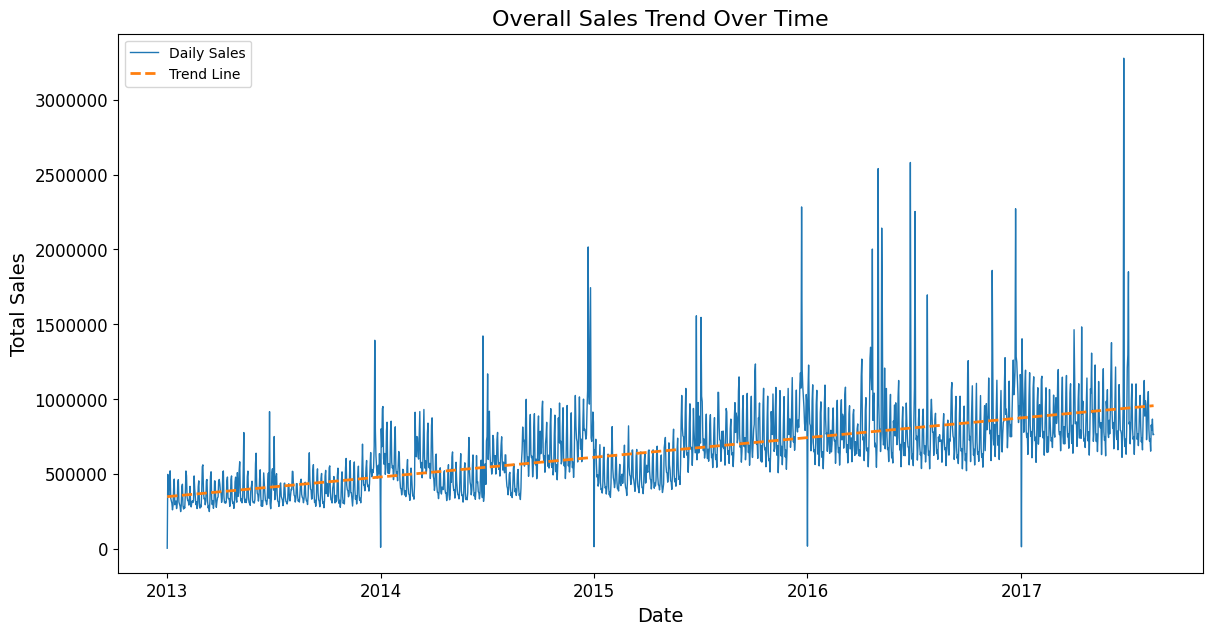

In [19]:
# Plotting overall sales trend
plt.figure(figsize=(14, 7))
plt.plot(sales_trend['date'], sales_trend['sales'],
         color=palette[0], linewidth=1, label='Daily Sales')
plt.title('Overall Sales Trend Over Time', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Total Sales', fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=12)

# Formatting y-axis to avoid exponents
plt.gca().get_yaxis().get_major_formatter().set_scientific(False)

# Adding a trend line for better visualization
z = np.polyfit(sales_trend['date'].apply(lambda x: x.toordinal()), sales_trend['sales'], 1)
p = np.poly1d(z)
plt.plot(sales_trend['date'], p(sales_trend['date'].apply(lambda x: x.toordinal())), 
         color=palette[1], linestyle='--', linewidth=2, label='Trend Line')

plt.legend()
plt.show()

Key Observations:
1. **Volatility in Daily Sales:**
   - The sales data show significant volatility, with periodic spikes that suggest occasional high-sales days. These could be related to specific events, promotions, or seasonal peaks.

2. **General Trend:**
   - The orange trend line indicates that the overall sales trend is relatively flat throughout the period, with no significant long-term growth or decline. This suggests a stable market condition without substantial expansion or contraction in sales volume.

3. **Seasonal Patterns:**
   - The recurring peaks in sales might indicate a seasonal pattern. For instance, sales spikes around the same time each year could suggest increased buying during holidays or special events.

4. **Outliers:**
   - There are several extreme spikes in sales, notably in the years 2016 and 2017. These outliers could be due to extraordinary market events or could be data errors; further investigation is required.

5. **Stability of the Trend Line:**
   - Despite the high variability in daily sales, the trend line remains consistently in the mid-range of the sales figures, suggesting that while day-to-day sales are unpredictable, the overall business performance is steady.


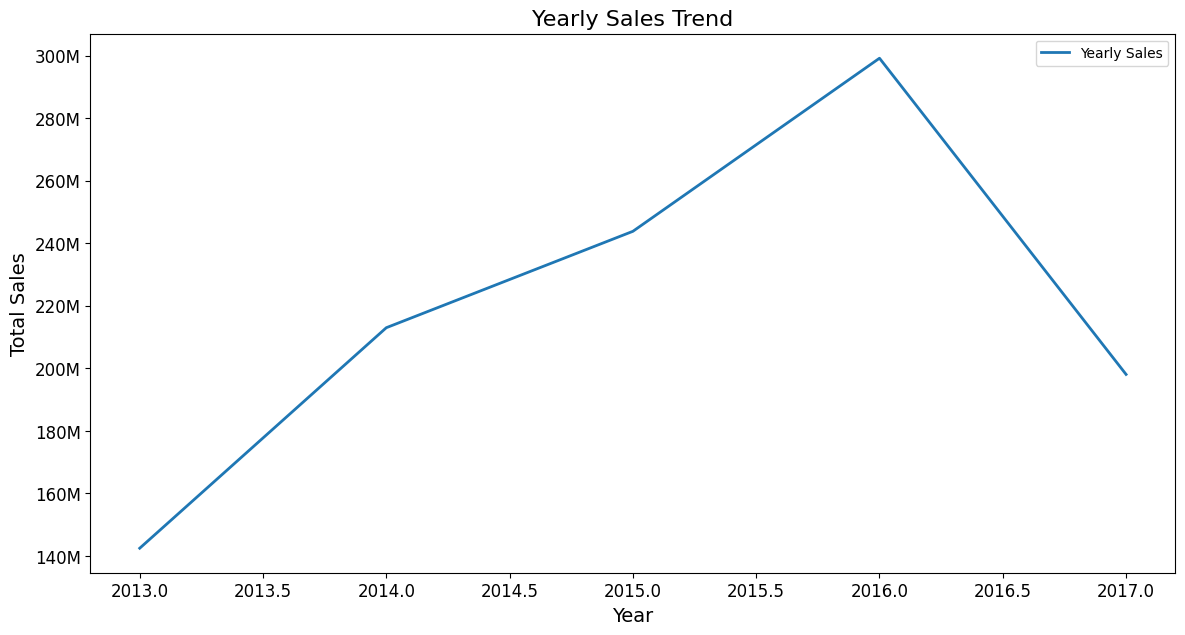

In [20]:
# Plotting yearly sales trend
plt.figure(figsize=(14, 7))
plt.plot(yearly_sales_trend['year'], yearly_sales_trend['sales'],
         color=palette[0], linewidth=2, label='Yearly Sales')
plt.title('Yearly Sales Trend', fontsize=16)
plt.xlabel('Year', fontsize=14)
plt.ylabel('Total Sales', fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=12)

plt.gca().get_yaxis().set_major_formatter(FuncFormatter(millions))

plt.legend()
plt.show()

Key Observations:
1. **Growth Trend (2013-2015):**
   - The sales exhibit a steady growth from 2013 through the end of 2015, indicating a successful period for the business with increasing revenue year over year.

2. **Peak and Sharp Decline:**
   - Sales peak dramatically in 2016, reaching their highest point before a sharp decline occurs. This sudden drop could be indicative of market saturation, external economic factors, or internal issues such as supply chain disruptions.

3. **Rapid Decrease (2016-2017):**
   - The rapid decrease in sales in late 2016 continuing into 2017 warrants investigation. Factors such as changes in consumer behavior, increased competition, or economic downturns might have contributed to this trend.

4. **Implications of Sales Volatility:**
   - The volatility observed, especially between 2016 and 2017, could impact planning and operations, suggesting a need for more robust risk management strategies.

### Sales Distribution Across Stores and Product Families

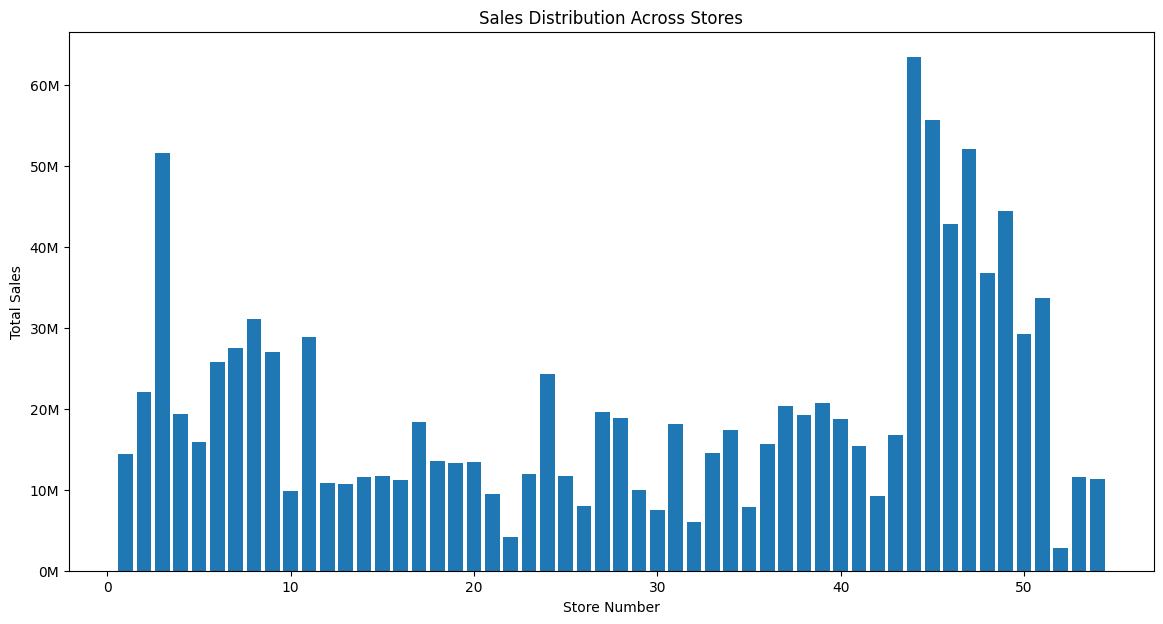

In [65]:
# Aggregate sales by store and product family
store_sales = train_merged.groupby('store_nbr')['sales'].sum().sort_values(ascending=False).reset_index()
family_sales = train_merged.groupby(
    'family')['sales'].sum().sort_values(ascending=False).reset_index()

# Plot sales distribution across stores
plt.figure(figsize=(14, 7))
plt.bar(store_sales['store_nbr'], store_sales['sales'])
plt.xlabel('Store Number')
plt.ylabel('Total Sales')
plt.title('Sales Distribution Across Stores')
# Formatting y-axis exponents
plt.gca().get_yaxis().set_major_formatter(FuncFormatter(millions))
plt.show()

Key Observations:
1. **Variability in Sales Performance:**
   - The chart reveals considerable variability in sales among the stores. Some stores (like the ones labeled around 40 and 50) significantly outperform others, suggesting possible differences in store size, location, customer base, or management efficiency.

2. **High Performing Stores:**
   - Notably, the store at position 40 exhibits the highest sales, potentially making it a model of operational success or a beneficiary of favorable market conditions.

3. **Lower Sales in Many Stores:**
   - Several stores, particularly those in the early sequence (around 0 to 20), show relatively low sales figures, which could indicate issues with location, local competition, or store management practices.

4. **Cluster Patterns:**
   - There seems to be a clustering of higher sales around specific store numbers, particularly in the later numbers (40 to 50). This pattern might reflect regional advantages, demographic factors, or strategic placement of flagship stores.

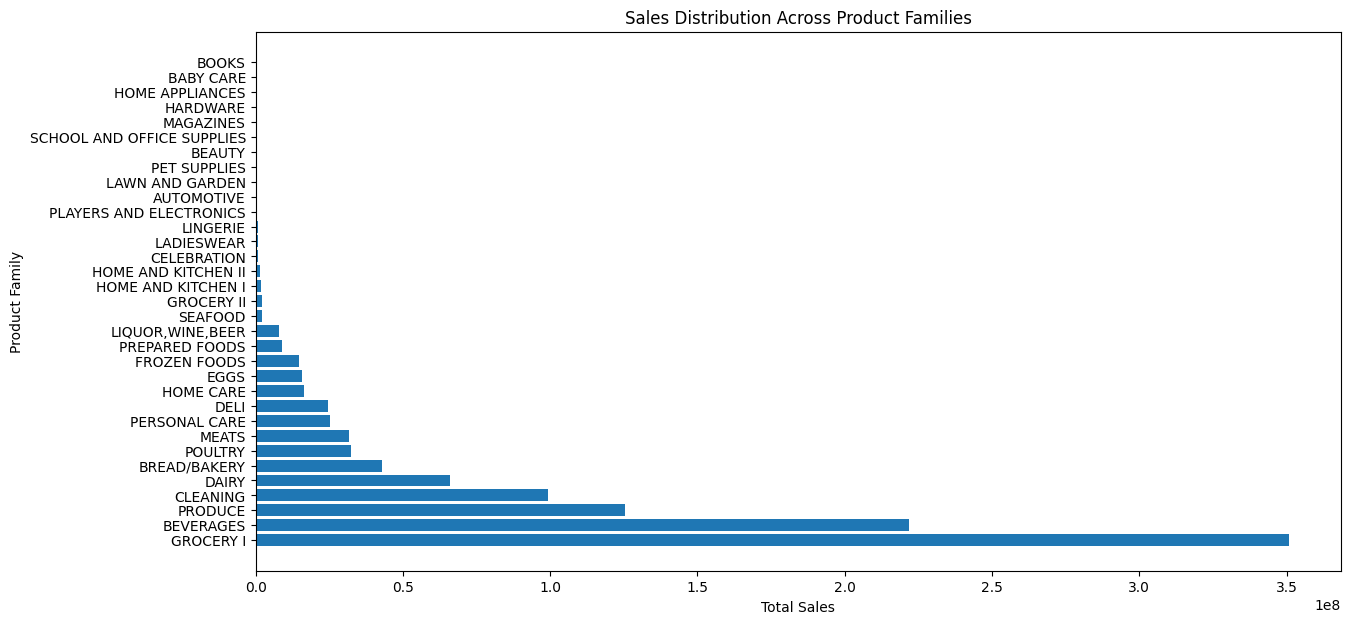

In [22]:
# Plot sales distribution across product families
plt.figure(figsize=(14, 7))
plt.barh(family_sales['family'], family_sales['sales'])
plt.xlabel('Total Sales')
plt.ylabel('Product Family')
plt.title('Sales Distribution Across Product Families')
plt.show()

Key Observations:
1. **Dominant Product Families:**
   - 'Grocery I' leads in sales by a significant margin, indicating its central role in the store's offerings. Following are 'Beverages' and 'Dairy,' which also show strong sales performances.

2. **Middle-tier Performers:**
   - Products like 'Cleaning Products,' 'Personal Care,' and 'Meats' represent the middle tier in sales. These categories are essential but attract less spending compared to top-tier product families.

3. **Low Sales in Niche Categories:**
   - Categories such as 'Books,' 'Baby Care,' and 'Home Appliances' are at the lower end of the sales spectrum. These may represent niche markets within the store or items that are not primary drivers of customer visits.

4. **Implications for Inventory and Marketing:**
   - The significant variation in sales across categories suggests potential adjustments in inventory levels, marketing focus, and store layout to optimize sales and customer experience.

### Impact of Holidays

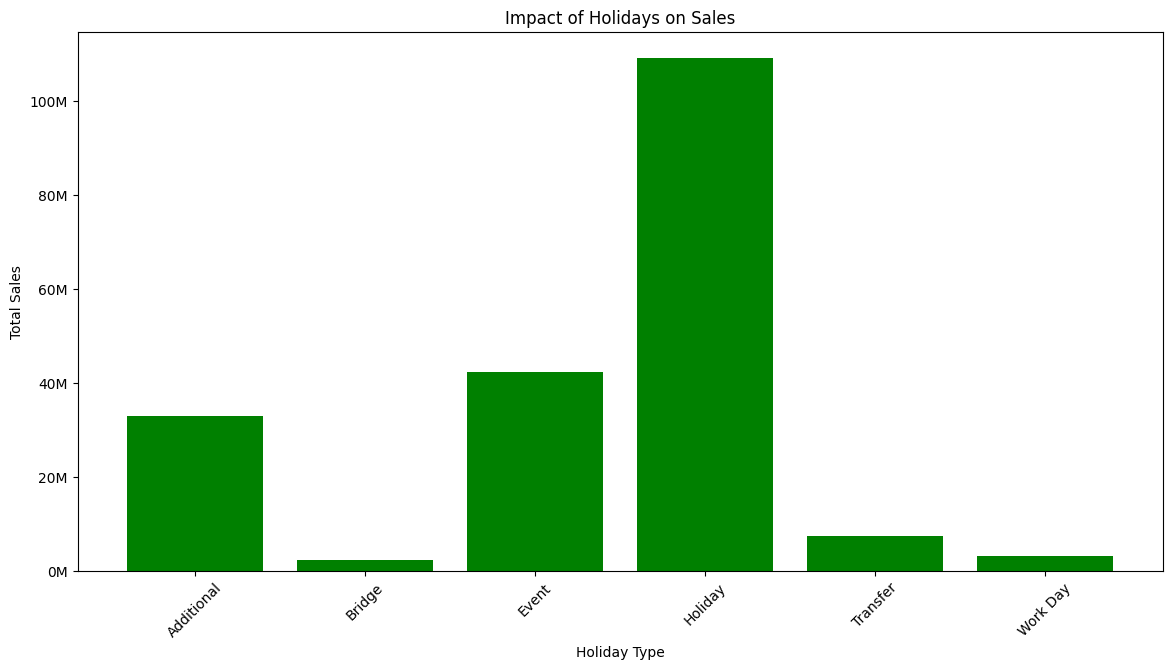

In [64]:
# Aggregate sales by holiday status
holiday_sales = train_merged.groupby(
    'holiday_type')['sales'].sum().reset_index()

# Exclude the 'None' category from the data
holiday_sales = holiday_sales[holiday_sales['holiday_type'] != 'None']

# Plot impact of holidays on sales
plt.figure(figsize=(14, 7))
plt.bar(holiday_sales['holiday_type'], holiday_sales['sales'], color='green')
plt.xlabel('Holiday Type')
plt.ylabel('Total Sales')
plt.title('Impact of Holidays on Sales')
plt.xticks(rotation=45)
# Formatting y-axis exponents
plt.gca().get_yaxis().set_major_formatter(FuncFormatter(millions))
plt.show()

Key Observations:
1. **Dominant Holiday Sales:**
   - The 'Holiday' category shows a significant peak, dwarfing sales from other types of special days. This suggests that recognized holidays drive substantial consumer spending, likely due to traditional shopping spikes during these periods.

2. **Comparative Analysis:**
   - 'Additional' and 'Event' days also contribute to sales, though to a much lesser extent compared to full holidays. These might represent minor or localized holidays and events that still manage to attract additional sales.

3. **Lower Impact Days:**
   - 'Bridge' and 'Transfer' days, as well as 'Work Day', show relatively low sales figures. This indicates that these days do not have a significant commercial impact and are perhaps regular working days or transitions between holidays without specific promotions.

Strategic Insights:
- **Maximize Holiday Sales:**
   - Given the overwhelming sales impact of major holidays, strategies should be developed to further capitalize on these periods, such as exclusive holiday promotions, limited-time offers, and special holiday inventory.

- **Leverage Events and Additional Days:**
   - Although these days show smaller sales figures, there's potential to increase their profitability through targeted marketing campaigns and event-specific promotions.

- **Evaluate Promotion Efficiency:**
   - For days showing minimal sales impact, evaluate the efficiency of any promotions or special efforts deployed and consider reallocating resources to more profitable periods.


## **Hypotheses Testing**

Null Hypothesis (H0a): Promotions do not have a significant impact on sales.  

Alternative Hypothesis (H1a): Promotions have a significant impact on sales.

In [24]:
# Splitting the data into promotional and non-promotional periods
promotional_sales = train[train['onpromotion'] > 0]['sales']
non_promotional_sales = train[train['onpromotion'] == 0]['sales']

# Calculating descriptive statistics
promotional_mean = promotional_sales.mean()
non_promotional_mean = non_promotional_sales.mean()
promotional_std = promotional_sales.std()
non_promotional_std = non_promotional_sales.std()

print(f"Promotional Sales - Mean: {promotional_mean}, Std: {promotional_std}")
print(f"Non-Promotional Sales - Mean: {non_promotional_mean}, Std: {non_promotional_std}")


Promotional Sales - Mean: 1137.6937303133943, Std: 1928.5887066373123
Non-Promotional Sales - Mean: 158.2466813936427, Std: 614.8944509454778


In [25]:
# Performing t-test
t_stat, p_value = ttest_ind(promotional_sales, non_promotional_sales)

print(f"T-Statistic: {t_stat}, P-Value: {p_value}")

# Interpreting the results
alpha = 0.05
if p_value < alpha:
    print("We Reject the null hypothesis (H0a). Promotions have a significant impact on sales.")
else:
    print("Fail to reject the null hypothesis (H0a). Promotions do not have a significant impact on sales.")

T-Statistic: 664.1236909096903, P-Value: 0.0
We Reject the null hypothesis (H0a). Promotions have a significant impact on sales.


Null Hypothesis (H0b): Oil prices do not significantly impact sales.  

Alternative Hypothesis (H1b): Oil prices significantly impact sales.

In [26]:
# Removing rows with missing oil prices
oil_merged_data = train_merged.dropna(subset=['dcoilwtico'])

# Performing correlation analysis
correlation = oil_merged_data['sales'].corr(oil_merged_data['dcoilwtico'])
print(f"Correlation between sales and oil prices: {correlation}")

Correlation between sales and oil prices: -0.07542992345237809


In [27]:
# Performing linear regression analysis
X = oil_merged_data['dcoilwtico']
y = oil_merged_data['sales']
X = sm.add_constant(X)  # Adds a constant term to the predictor

model = sm.OLS(y, X).fit()
summary = model.summary()
print(summary)

                            OLS Regression Results                            
Dep. Variable:                  sales   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                 1.748e+04
Date:                Thu, 08 Aug 2024   Prob (F-statistic):               0.00
Time:                        09:33:18   Log-Likelihood:            -2.5735e+07
No. Observations:             3054348   AIC:                         5.147e+07
Df Residuals:                 3054346   BIC:                         5.147e+07
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        579.8744      1.786    324.672      0.0

In [28]:
# Extract the p-value for the oil price coefficient
p_value = model.pvalues['dcoilwtico']
print(f"P-Value for oil prices: {p_value}")

# Interpret the results
alpha = 0.05
if p_value < alpha:
    print("Reject the null hypothesis (H0b). Oil prices significantly impact sales.")
else:
    print("Fail to reject the null hypothesis (H0b). Oil prices do not significantly impact sales.")

P-Value for oil prices: 0.0
Reject the null hypothesis (H0b). Oil prices significantly impact sales.


## **Analytical Questions**

### 1. Checking if the train dataset complete (has all the required dates)?

In [29]:
# Determining the start and end dates in the train dataset
start_date = train['date'].min()
end_date = train['date'].max()

# Creating a complete date range from start to end date
complete_date_range = pd.date_range(start=start_date, end=end_date)

# Extracting the unique dates from the train dataset
unique_dates_in_train = train['date'].unique()

# Finding any missing dates by comparing the complete date range to the dates in the train dataset
missing_dates = set(complete_date_range) - set(unique_dates_in_train)

print(f"Start Date in Train Dataset: {start_date}")
print(f"End Date in Train Dataset: {end_date}")
print(f"Number of Unique Dates in Train Dataset: {len(unique_dates_in_train)}")
print(f"Number of Dates in Complete Range: {len(complete_date_range)}")
print(f"Missing Dates: {sorted(missing_dates)}")

Start Date in Train Dataset: 2013-01-01 00:00:00
End Date in Train Dataset: 2017-08-15 00:00:00
Number of Unique Dates in Train Dataset: 1684
Number of Dates in Complete Range: 1688
Missing Dates: [Timestamp('2013-12-25 00:00:00'), Timestamp('2014-12-25 00:00:00'), Timestamp('2015-12-25 00:00:00'), Timestamp('2016-12-25 00:00:00')]


### 2. Determining which dates have the lowest and highest sales for each year(excluding days the store was closed)?

In [30]:
# Identifying dates when stores were closed (i.e., zero transactions)
closed_dates = transactions[transactions['transactions'] == 0]['date'].unique()

# Filtering out closed dates from the sales data
sales_data = train_merged[~train_merged['date'].isin(closed_dates)]

In [31]:
# Initializing dictionaries to store the results
lowest_sales_dates = {}
highest_sales_dates = {}

# Grouping by year and find the dates with the lowest and highest sales
for year, group in sales_data.groupby('year'):
    lowest_sales_row = group.loc[group['sales'].idxmin()]
    highest_sales_row = group.loc[group['sales'].idxmax()]
    lowest_sales_dates[year] = (lowest_sales_row['date'], lowest_sales_row['sales'])
    highest_sales_dates[year] = (highest_sales_row['date'], highest_sales_row['sales'])

# Creating DataFrames to display the results
lowest_sales_df = pd.DataFrame(list(lowest_sales_dates.items()), 
                               columns=['Year', 'Lowest Sales Data'])
highest_sales_df = pd.DataFrame(list(highest_sales_dates.items()), 
                                columns=['Year', 'Highest Sales Data'])

# Splitting the tuple into separate columns
lowest_sales_df[['Lowest Sales Date', 'Lowest Sales']] = pd.DataFrame(
    lowest_sales_df['Lowest Sales Data'].tolist(), index=lowest_sales_df.index)
highest_sales_df[['Highest Sales Date', 'Highest Sales']] = pd.DataFrame(
    highest_sales_df['Highest Sales Data'].tolist(), index=highest_sales_df.index)

# Dropping the original tuple columns
lowest_sales_df.drop(columns=['Lowest Sales Data'], inplace=True)
highest_sales_df.drop(columns=['Highest Sales Data'], inplace=True)

print("Dates with the Lowest Sales for Each Year:")
print(lowest_sales_df)
print("\nDates with the Highest Sales for Each Year:")
print(highest_sales_df)

Dates with the Lowest Sales for Each Year:
   Year Lowest Sales Date  Lowest Sales
0  2013        2013-01-01           0.0
1  2014        2014-01-01           0.0
2  2015        2015-01-01           0.0
3  2016        2016-01-01           0.0
4  2017        2017-01-01           0.0

Dates with the Highest Sales for Each Year:
   Year Highest Sales Date  Highest Sales
0  2013         2013-11-12      46271.000
1  2014         2014-12-08      45361.000
2  2015         2015-12-14      40351.460
3  2016         2016-05-02     124717.000
4  2017         2017-04-02      38422.625


### 3. Comparing the sales for each month across the years and determine which month of which year had the highest sales.

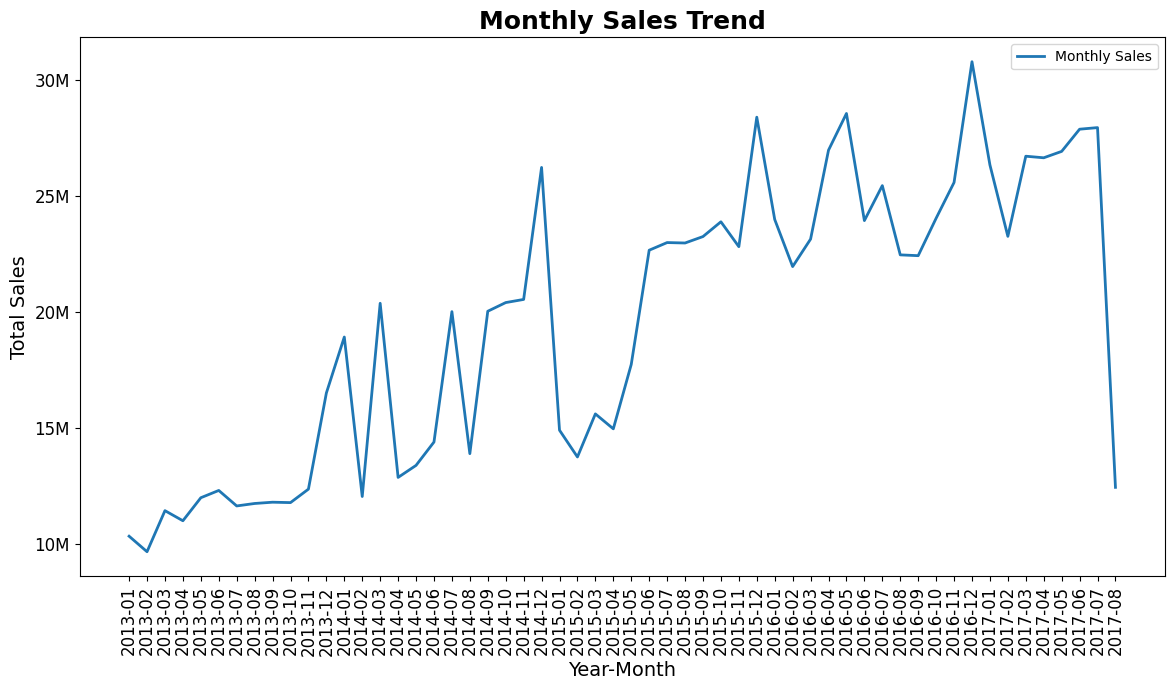

In [32]:
# Grouping by date and sum sales to get the overall sales trend over time
sales_trend = train_merged.groupby('date')['sales'].sum().reset_index()

# Grouping by year and month for monthly trend
sales_trend['year_month'] = sales_trend['date'].dt.to_period('M')
monthly_sales_trend = sales_trend.groupby('year_month')['sales'].sum().reset_index()


# Plotting monthly sales trend
plt.figure(figsize=(14, 7))
plt.plot(monthly_sales_trend['year_month'].astype(str),
         monthly_sales_trend['sales'], color=palette[0], linewidth=2, label='Monthly Sales')
plt.title('Monthly Sales Trend', fontsize=18, weight='bold')
plt.xlabel('Year-Month', fontsize=14)
plt.ylabel('Total Sales', fontsize=14)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.xticks(rotation=90)

# Formatting y-axis exponents
plt.gca().get_yaxis().set_major_formatter(FuncFormatter(millions))

plt.legend()
plt.show()

1. **General Trend**:
   - The overall trend indicates a steady increase in monthly sales from 2013 to 2017.
   - There are noticeable peaks and troughs, indicating seasonal variations and possibly promotional events or holidays affecting sales.

2. **Highest Sales Month**:
   - The highest sales month across all years is `May 2016`, with sales reaching approximately `30 million`. This peak is significantly higher than other months, suggesting a major event or promotion during that period.

3. **Seasonal Patterns**:
   - Sales tend to peak towards the end of the year, particularly in November and December, likely due to holiday shopping.
   - Another notable peak occurs around mid-year (June and July), which may correspond to mid-year sales events or summer holidays.

4. **Year-over-Year Comparison**:
   - Each year shows an increasing trend in sales for most months, indicating growth in business and possibly an expanding customer base.
   - The months of November and December consistently show higher sales across the years, reinforcing the impact of holiday shopping on sales performance.

5. **Significant Peaks**:
   - The graph shows significant peaks not only in May 2016 but also in December 2014, and November 2013, indicating these months had exceptionally high sales compared to their respective years.



### 4. Did the earthquake impact sales?

Note:A magnitude 7.8 earthquake struck Ecuador on April 16, 2016. People rallied in relief efforts donating water and other first need products which greatly affected supermarket sales for several weeks after the earthquake.

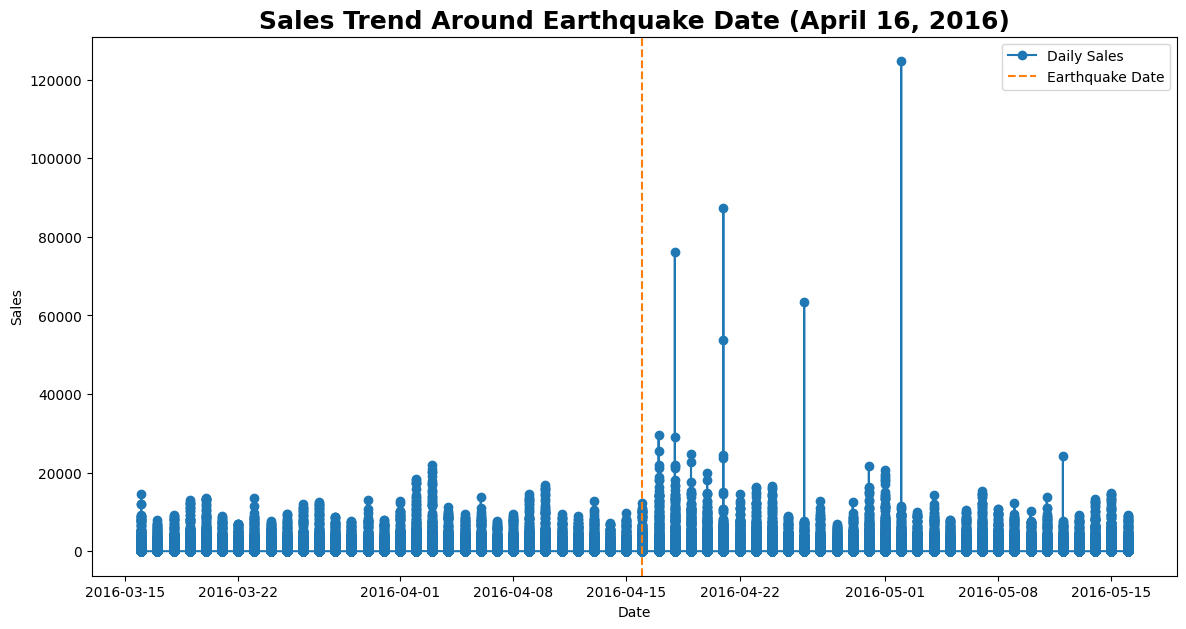

In [33]:
# Defining the period around the earthquake date (1 month before and 1 month after)
start_date = '2016-03-16'
end_date = '2016-05-16'
earthquake_date = '2016-04-16'

# Filtering data for the defined period
filtered_data = train[(train['date'] >= start_date) & (train['date'] <= end_date)]

plt.figure(figsize=(14, 7))
plt.plot(filtered_data['date'], filtered_data['sales'], marker='o', linestyle='-', color=palette[0], label='Daily Sales')
plt.axvline(pd.to_datetime(earthquake_date), color=palette[1], linestyle='--', label='Earthquake Date')
plt.title('Sales Trend Around Earthquake Date (April 16, 2016)',
          fontsize=18, weight='bold')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.legend()
plt.show()

1. **Immediate Sales Increase Post-Earthquake**:
   - There is a noticeable spike in sales immediately after the earthquake on April 16, 2016. This spike is evident within the first few days following the earthquake and is significantly higher compared to the sales before the earthquake.

2. **Sustained High Sales**:
   - Sales remain elevated for several weeks following the earthquake. This indicates that the earthquake had a prolonged impact on sales, likely due to ongoing relief efforts and increased demand for essential goods.

3. **Peak Sales**:
   - The highest sales point within the observed period occurs shortly after the earthquake, suggesting a direct correlation between the event and the surge in sales.

4. **Pre-Earthquake Sales Stability**:
   - Sales prior to the earthquake show a relatively stable pattern with minor fluctuations, indicating a normal sales period before the disruptive event.

In [34]:
# Defining periods before and after the earthquake
before_earthquake = filtered_data[filtered_data['date'] < earthquake_date]
after_earthquake = filtered_data[filtered_data['date'] >= earthquake_date]

# Performing t-test
t_stat, p_value = ttest_ind(
    before_earthquake['sales'], after_earthquake['sales'])

print(f"T-Statistic: {t_stat}, P-Value: {p_value}")

alpha = 0.05
if p_value < alpha:
    print("We Reject the null hypothesis. The earthquake had a significant impact on sales.")
else:
    print("We Fail to reject the null hypothesis. The earthquake did not have a significant impact on sales.")

T-Statistic: -8.452960671870839, P-Value: 2.873983188994139e-17
We Reject the null hypothesis. The earthquake had a significant impact on sales.


### 5. Are certain groups of stores selling more products? (Cluster, city, state, type)

Sales by Cluster

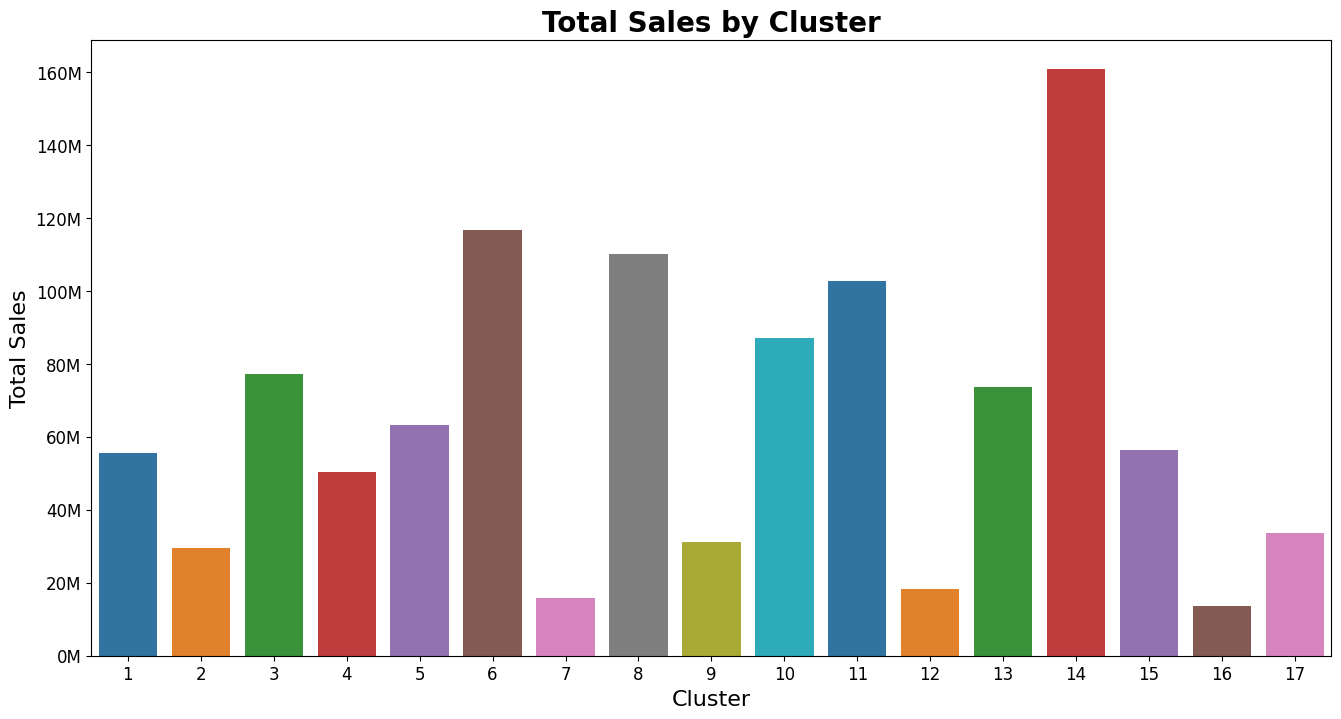

In [35]:
# Grouping by cluster and calculate total sales
cluster_sales = train_merged.groupby('cluster')['sales'].sum().reset_index()
cluster_sales = cluster_sales.sort_values(by='cluster', ascending= True)

# Plotting total sales by cluster
plt.figure(figsize=(16, 8))
sns.barplot(x='cluster', y='sales', data=cluster_sales, palette=palette)
plt.title('Total Sales by Cluster', fontsize=20, weight='bold')
plt.xlabel('Cluster', fontsize=16)
plt.ylabel('Total Sales', fontsize=16)
plt.gca().get_yaxis().set_major_formatter(plt.FuncFormatter(millions))
plt.xticks(ticks=range(len(cluster_sales)),
           labels=cluster_sales['cluster'].astype(int), fontsize=12)
plt.yticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

- **Cluster with Highest Sales**:
  - Cluster `14` stands out with the highest total sales, significantly outperforming other clusters with over `160M` in sales. This indicates a particularly strong performance, possibly due to a higher number of stores, larger store sizes, or a more affluent customer base.

- **Other High-Performing Clusters**:
  - Clusters `6` and `8` also show high sales, with each generating over `120M` in sales. These clusters, along with cluster 14, make up the top three clusters in terms of sales performance.
  - Clusters `3`, `11`, and `13` follow closely behind, each with sales ranging between `80M` and `100M`. These clusters represent the mid-high range of sales performance.

- **Lower-Performing Clusters**:
  - Clusters `2`, `7`, `9`, `12`, and `16` have the lowest total sales, each generating less than `40M`. These clusters might consist of fewer stores, smaller store sizes, or be located in regions with lower customer demand.

Sales by City

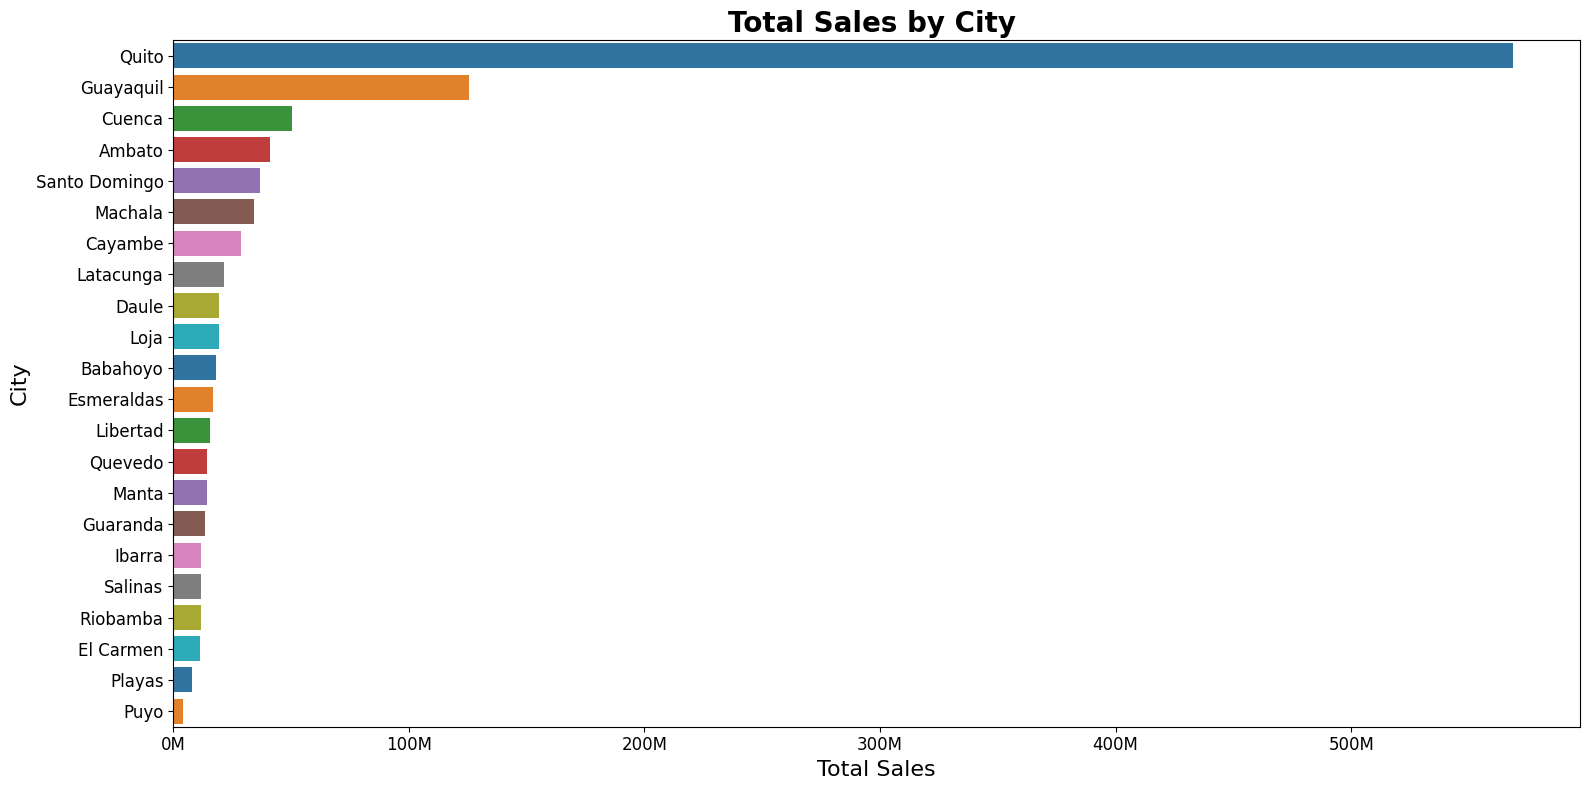

In [36]:
# Grouping by city and calculate total sales
city_sales = train_merged.groupby('city')['sales'].sum().reset_index()
city_sales = city_sales.sort_values(by='sales', ascending=False)

# Plotting total sales by city
plt.figure(figsize=(16, 8))
sns.barplot(x='sales', y='city', data=city_sales, palette=palette, orient='h')
plt.title('Total Sales by City ', fontsize=20, weight='bold')
plt.xlabel('Total Sales', fontsize=16)
plt.ylabel('City', fontsize=16)
plt.gca().get_xaxis().set_major_formatter(plt.FuncFormatter(millions))
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

- **City with Highest Sales**:
  - `Quito` stands out with the highest total sales, significantly outperforming other cities with over `500M` in sales. This indicates that Quito is a major commercial hub with high customer demand and purchasing power.

- **Other High-Performing Cities**:
  - `Guayaquil` comes second at `120M`sale sales, `Cuenca` follows with around `80M` in sales, showing strong performance as well. It is a key city with substantial sales figures.
  - `Ambato` is next with over `40M` in sales, indicating a solid market presence.
  - Other notable cities include `Cayambe` and `Daule`, each contributing significantly to the total sales but with lower figures compared to the top three cities.

- **Lower-Performing Cities**:
  - Cities like `Babahoyo`, `El Carmen`, and `Guaranda` show relatively lower total sales, each generating less than `20M`. These cities might have fewer stores, smaller store sizes, or be located in regions with lower customer demand.

Sales by state

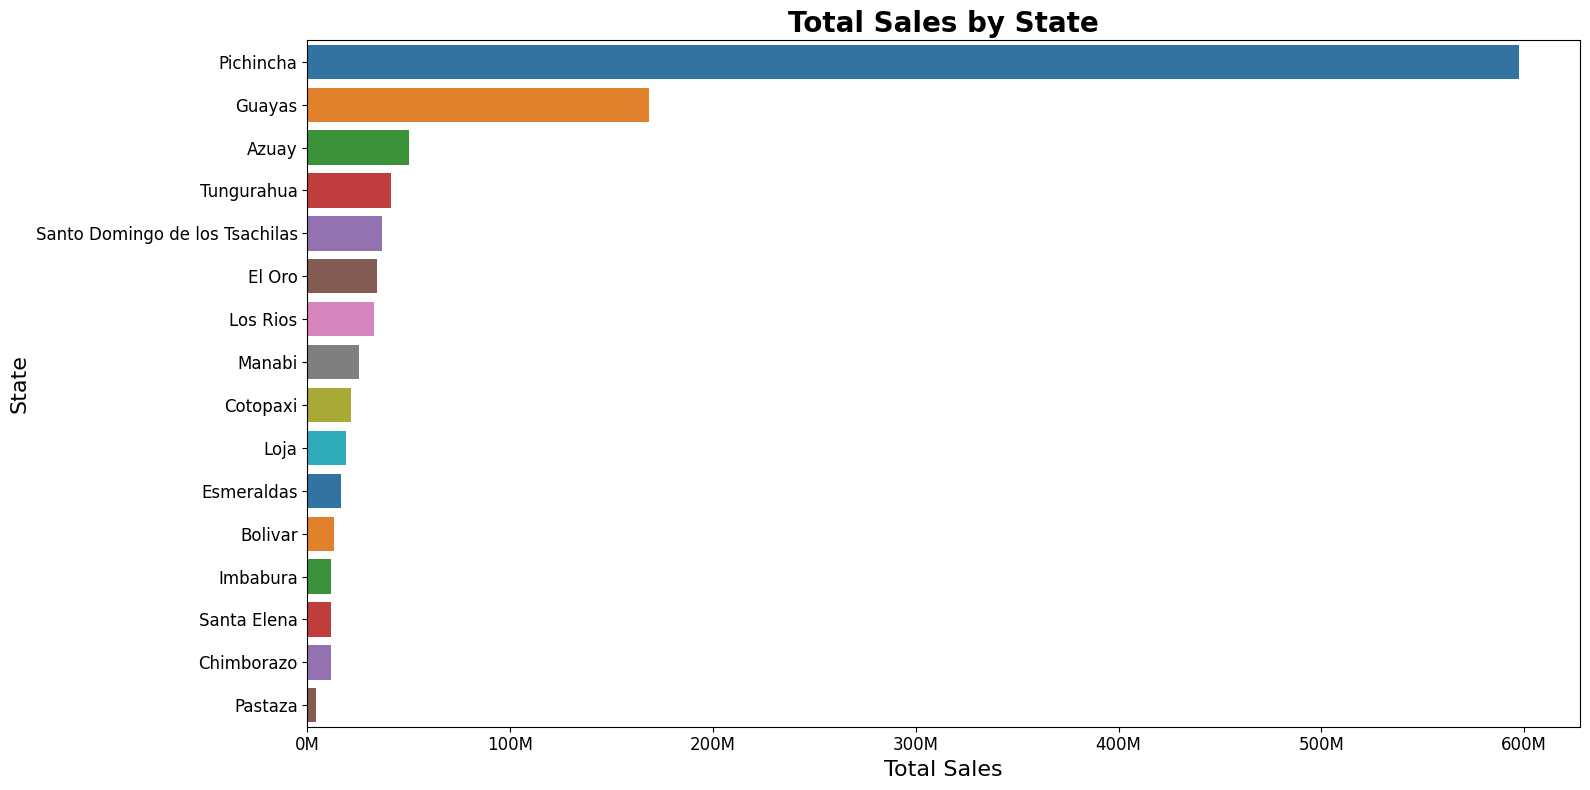

In [37]:
# Grouping by state and calculate total sales
state_sales = train_merged.groupby('state')['sales'].sum().reset_index()
state_sales = state_sales.sort_values(by='sales', ascending=False)

# Plotting total sales by state
plt.figure(figsize=(16, 8))
sns.barplot(x='sales', y='state', data=state_sales,
            palette=palette, orient='h')
plt.title('Total Sales by State', fontsize=20, weight='bold')
plt.xlabel('Total Sales', fontsize=16)
plt.ylabel('State', fontsize=16)
plt.gca().get_xaxis().set_major_formatter(plt.FuncFormatter(millions))
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

- **State with Highest Sales**:
  - `Pichincha` dominates with the highest total sales, significantly outperforming other states with `600M` in sales. This indicates that Pichincha, likely due to the presence of the capital city `Quito`, is a major commercial hub with high customer demand.

- **Other High-Performing States**:
  - `Guayas` follows with just below `200M` in sales, showing strong performance as well. It is a key state with substantial sales figures.
  - `Azuay`, `Santo Domingo de los Tsáchilas`, and other states each contribute significantly to the total sales but with lower figures compared to the top two states.

- **Lower-Performing States**:
  - States like `Pastaza`, `Chimborazo`, and `Santa Elena` show relatively lower total sales, each generating less than 10M. These states might have fewer stores, smaller store sizes, or be located in regions with lower customer demand.


Sales by Store Type

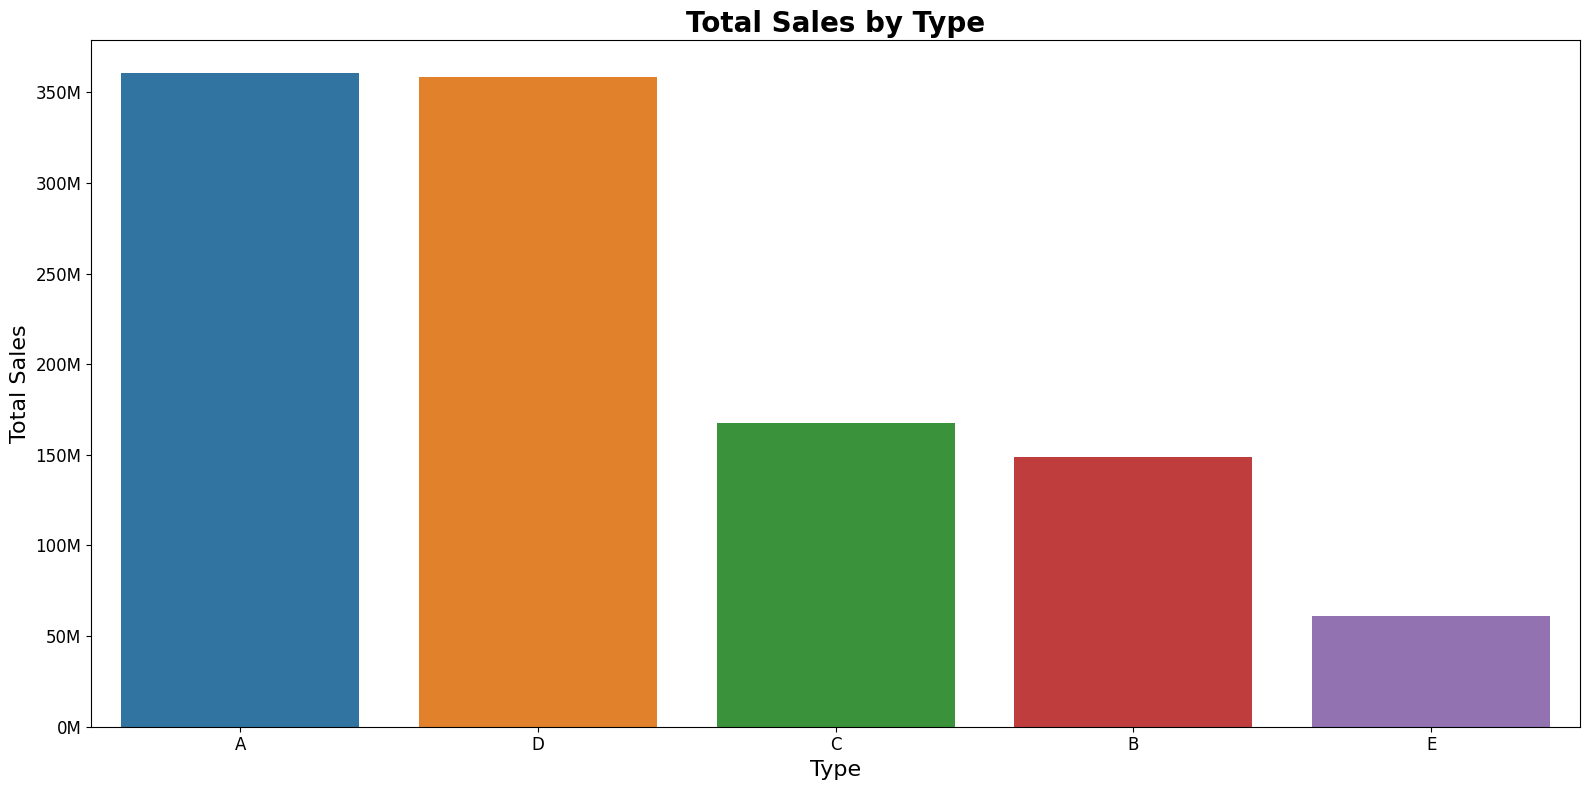

In [38]:
# Grouping by type and calculate total sales
type_sales = train_merged.groupby('store_type')['sales'].sum().reset_index()
type_sales = type_sales.sort_values(by='sales', ascending=False)

# Plotting total sales by type
plt.figure(figsize=(16, 8))
sns.barplot(x='store_type', y='sales', data=type_sales.sort_values(
    by='sales', ascending=False), palette=palette)
plt.title('Total Sales by Type', fontsize=20, weight='bold')
plt.xlabel('Type', fontsize=16)
plt.ylabel('Total Sales', fontsize=16)
plt.gca().get_yaxis().set_major_formatter(plt.FuncFormatter(millions))
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

- **Type with Highest Sales**:
  - Store types `A` and `D` dominate with the highest total sales, each generating over `350M`. This indicates that these store types are the most popular or have the highest number of stores.

- **Other High-Performing Types**:
  - Store types `C` and `B` follow with substantial sales, over `150M` each. These types also contribute significantly to the overall sales.

- **Lower-Performing Types**:
  - Store type `E` shows the lowest total sales, significantly less than the other types, with sales just over `50M`. This type might represent fewer stores or stores with lower customer demand.

### 6. Are sales affected by promotions, oil prices and holidays?

#### Impact of Promotions on Sales

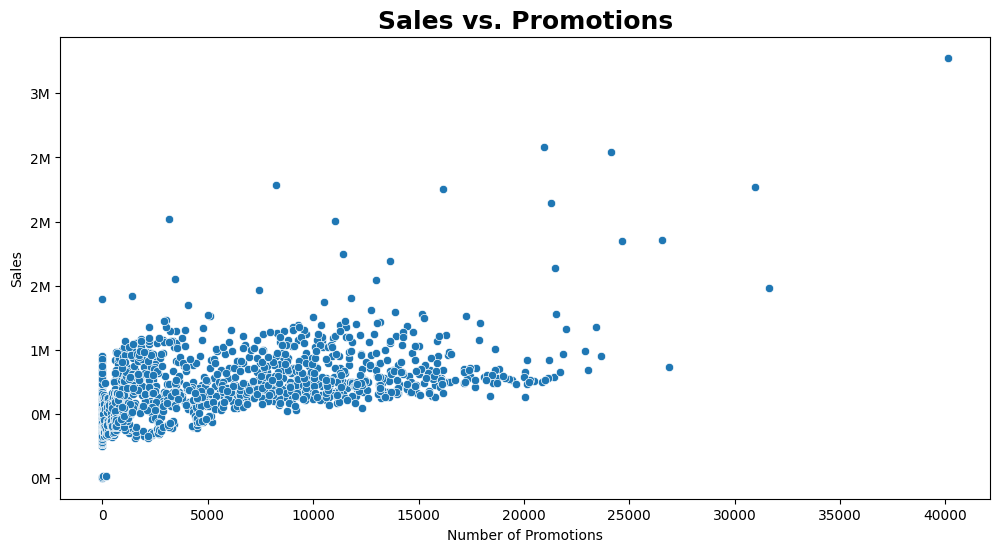

In [39]:
# Grouping the train data by date and sum the sales and onpromotion columns
promotions_sales_df = train_merged.groupby('date').agg(
    {'sales': 'sum', 'onpromotion': 'sum'}).reset_index()

# Plotting sales vs. promotions
plt.figure(figsize=(12, 6))
sns.scatterplot(x='onpromotion', y='sales', data=promotions_sales_df, palette=palette)
plt.title('Sales vs. Promotions', fontsize=18, weight='bold')
plt.xlabel('Number of Promotions')
plt.ylabel('Sales')
ax = plt.gca()
ax.yaxis.set_major_formatter(ticker.FuncFormatter(millions))

plt.show()

In [40]:
# Calculating the correlation between sales and onpromotion
promotions_correlation = promotions_sales_df['sales'].corr(promotions_sales_df['onpromotion'])
promotions_correlation

0.5956484412473976

1. **Positive Correlation:**
   - The correlation coefficient is approximately `0.60`, indicating a moderate positive relationship between the number of promotions and sales. As the number of promotions increases, sales generally tend to increase.

2. **Outliers:**
   - There are notable outliers, particularly `one` data point where the number of promotions reaches around `40,000` and sales exceed `3` million. These outliers can significantly influence the overall analysis and warrant further investigation.

3. **Diminishing Returns:**
   - Beyond approximately `10,000` promotions, the increase in sales does not proportionally match the increase in promotions. This indicates diminishing returns on promotions, where additional promotions yield smaller increases in sales.

4. **Cluster of Data Points:**
   - A significant cluster of data points is observed between `0` to `10,000` promotions, with sales ranging mostly between `0` to `1` million. This indicates that most promotional activities fall within this range and still generate substantial sales.

5. **Non-linear Relationship:**
   - While the overall trend shows a positive correlation, the relationship between promotions and sales is not strictly linear. For example, increasing promotions from `20,000` to `30,000` does not lead to a proportionate increase in sales, suggesting other factors may also be influencing sales performance.

6. **Marketing Strategy Implications:**
   - The analysis suggests that businesses should evaluate the optimal number of promotions needed to maximize sales. Excessive promotional activities, particularly beyond `10,000` promotions, appear to yield diminishing returns and may not be cost-effective.


#### Impact of Oil Prices on Sales

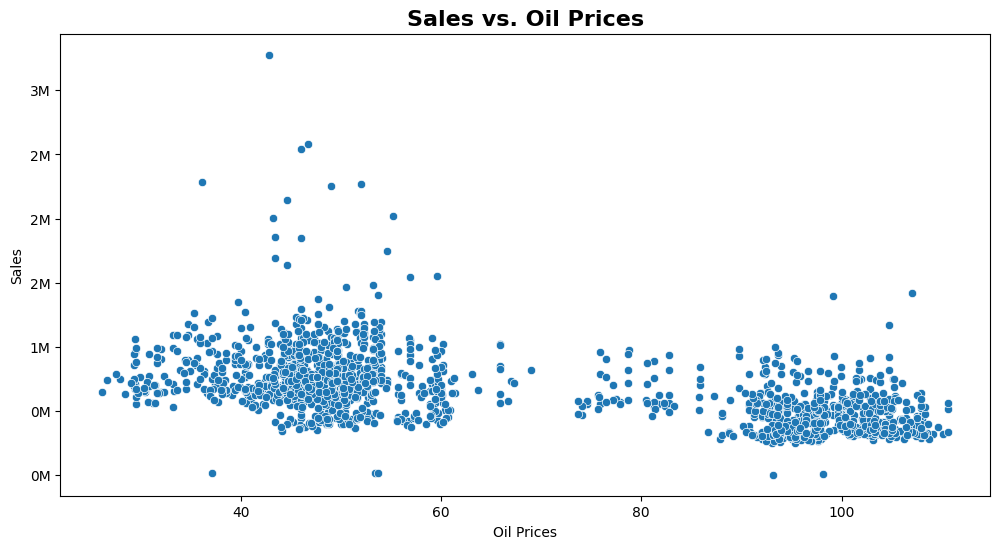

In [41]:
# Grouping the merged data by date and sum the sales
sales_oil_df_grouped = train_merged.groupby('date').agg({'sales': 'sum', 'dcoilwtico': 'mean'}).reset_index()

# Plotting sales vs. oil prices
plt.figure(figsize=(12, 6))
sns.scatterplot(x='dcoilwtico', y='sales', data=sales_oil_df_grouped, palette=palette)
plt.title('Sales vs. Oil Prices', fontsize=16, weight='bold')
plt.xlabel('Oil Prices')
plt.ylabel('Sales')
ax = plt.gca()
ax.yaxis.set_major_formatter(ticker.FuncFormatter(millions))

plt.show()

In [42]:
# Calculating the correlation between sales and oil prices
oil_correlation = sales_oil_df_grouped['sales'].corr(sales_oil_df_grouped['dcoilwtico'])
oil_correlation

-0.5539891429786324

1. **Negative Correlation:**
   - The correlation coefficient is approximately `-0.55`, indicating a moderate negative relationship between oil prices and sales. This suggests that as oil prices increase, sales tend to decrease.

2. **Clusters of Data Points:**
   - Three main clusters of data points are visible:
     - **Oil Prices between `40` and `60`:** This cluster shows a wide range of sales values, mostly between `0` and `2` million.
     - **Oil Prices around `80`:** This cluster has fewer data points, with sales generally below `1` million.
     - **Oil Prices between `100` and `110`:** This cluster also shows a range of sales values, mostly between `0` and `1` million.

3. **Outliers:**
   - There are a few outliers where sales exceed `3` million, regardless of oil prices. These points can significantly influence the overall analysis and may require further investigation to understand the context behind such high sales.

4. **Distribution of Sales:**
   - The majority of sales data points are below `1` million, regardless of oil price levels. However, there is a notable density of sales below `2` million when oil prices are between `40` and `60`.

5. **Potential Influences:**
   - The moderate negative correlation suggests that higher oil prices may have an adverse effect on sales, possibly due to increased costs for consumers and businesses, reducing their purchasing power or expenditure on other goods.


#### Impact of Holidays on Sales

In [43]:
# Basic summary statistics of sales on holidays vs. non-holidays
sales_summary = train_merged.groupby('holiday_type')['sales'].describe()

sales_summary

,count,mean,std,min,25%,50%,75%,max
holiday_type,,,,,,,,
Additional,67716.0,487.628925,1414.266388,0.0,0.0,18.0,292.0000,31851.158
Bridge,5346.0,446.750854,1309.716490,0.0,0.0,16.0,273.9350,21367.000
Event,99792.0,425.660065,1401.016019,0.0,1.0,16.0,236.0000,124717.000
Holiday,304722.0,358.433812,1153.161110,0.0,0.0,10.0,189.0000,89576.360
None,2551824.0,352.159181,1076.081977,0.0,0.0,11.0,193.0000,40351.460
Transfer,16038.0,467.753110,1373.064925,0.0,2.0,24.0,264.0045,23966.000
Work Day,8910.0,372.157524,1167.569933,0.0,0.0,8.0,203.0000,18222.000


1. **Additional Holidays**:
   - Highest average sales among all holiday types with an average of `487.63`.
   - Standard deviation is high at `1414.27`, indicating a wide range of sales values.
   - Median sales (50th percentile) is `18`, suggesting that a majority of sales values are clustered at the lower end despite the high mean.

2. **Bridge Holidays**:
   - Second highest average sales at `446.75`.
   - Standard deviation of `1309.72`, showing a significant spread in the data.
   - Median sales are `16`, similar to Additional Holidays, showing a lower concentration of sales.

3. **Events**:
   - Average sales are `425.66`, slightly lower than Bridge Holidays.
   - High standard deviation of `1401.02`.
   - Median sales of `16`, indicating a concentration of sales towards the lower end.

4. **Holidays**:
   - Average sales drop to `358.43`.
   - Standard deviation is lower at `1153.16` compared to Additional, Bridge, and Event holidays.
   - Median sales are `10`, showing a significant portion of sales are lower.

5. **Non-Holidays (None)**:
   - Average sales are `352.16`, the lowest among all categories except for Work Day.
   - Standard deviation of `1076.08`.
   - Median sales are `11`, indicating a higher concentration of lower sales values.

6. **Transfer Holidays**:
   - Average sales are relatively high at `467.75`.
   - Standard deviation is `1373.06`.
   - Median sales are `24`, higher than the median sales of other holiday types, indicating relatively higher sales even at the lower end.

7. **Work Days**:
   - Average sales are `372.16`.
   - Standard deviation of `1167.57`.
   - Median sales are `8`, showing a lower concentration of sales compared to other holiday types.

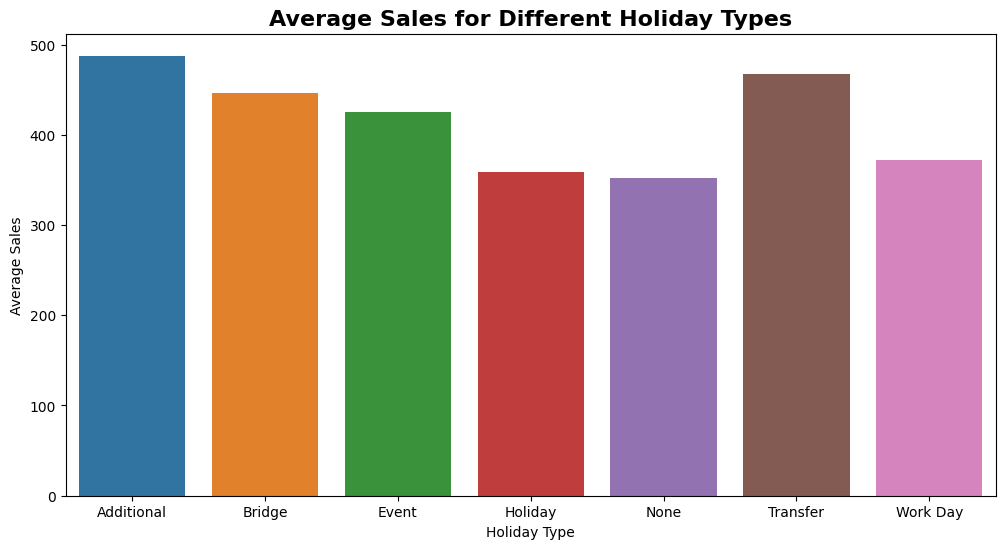

In [44]:
# Grouping by holiday type to get the total sales for each type
sales_by_holiday_type = train_merged.groupby('holiday_type')['sales'].mean().reset_index()

# Plotting average sales for different holiday types
plt.figure(figsize=(12, 6))
sns.barplot(x='holiday_type', y='sales',data=sales_by_holiday_type, palette=palette)
plt.title('Average Sales for Different Holiday Types',fontsize=16, weight='bold')
plt.xlabel('Holiday Type')
plt.ylabel('Average Sales')
plt.show()

- **Additional** and **Transfer** holidays result in the highest average sales, suggesting these holidays might drive significant consumer activity.
- **Bridge**, **Event**, and **Work Day** holidays also show relatively high average sales, indicating their potential importance for sales strategies.
- **Non-Holidays** (None) have the lowest average sales, which could imply that regular days without any special events or holidays are less likely to drive high sales.
- The high standard deviations across all categories indicate a wide variability in sales, highlighting the need for targeted marketing strategies to maximize sales on different holiday types.

### 7. What analysis can we get from the date and its extractable features?

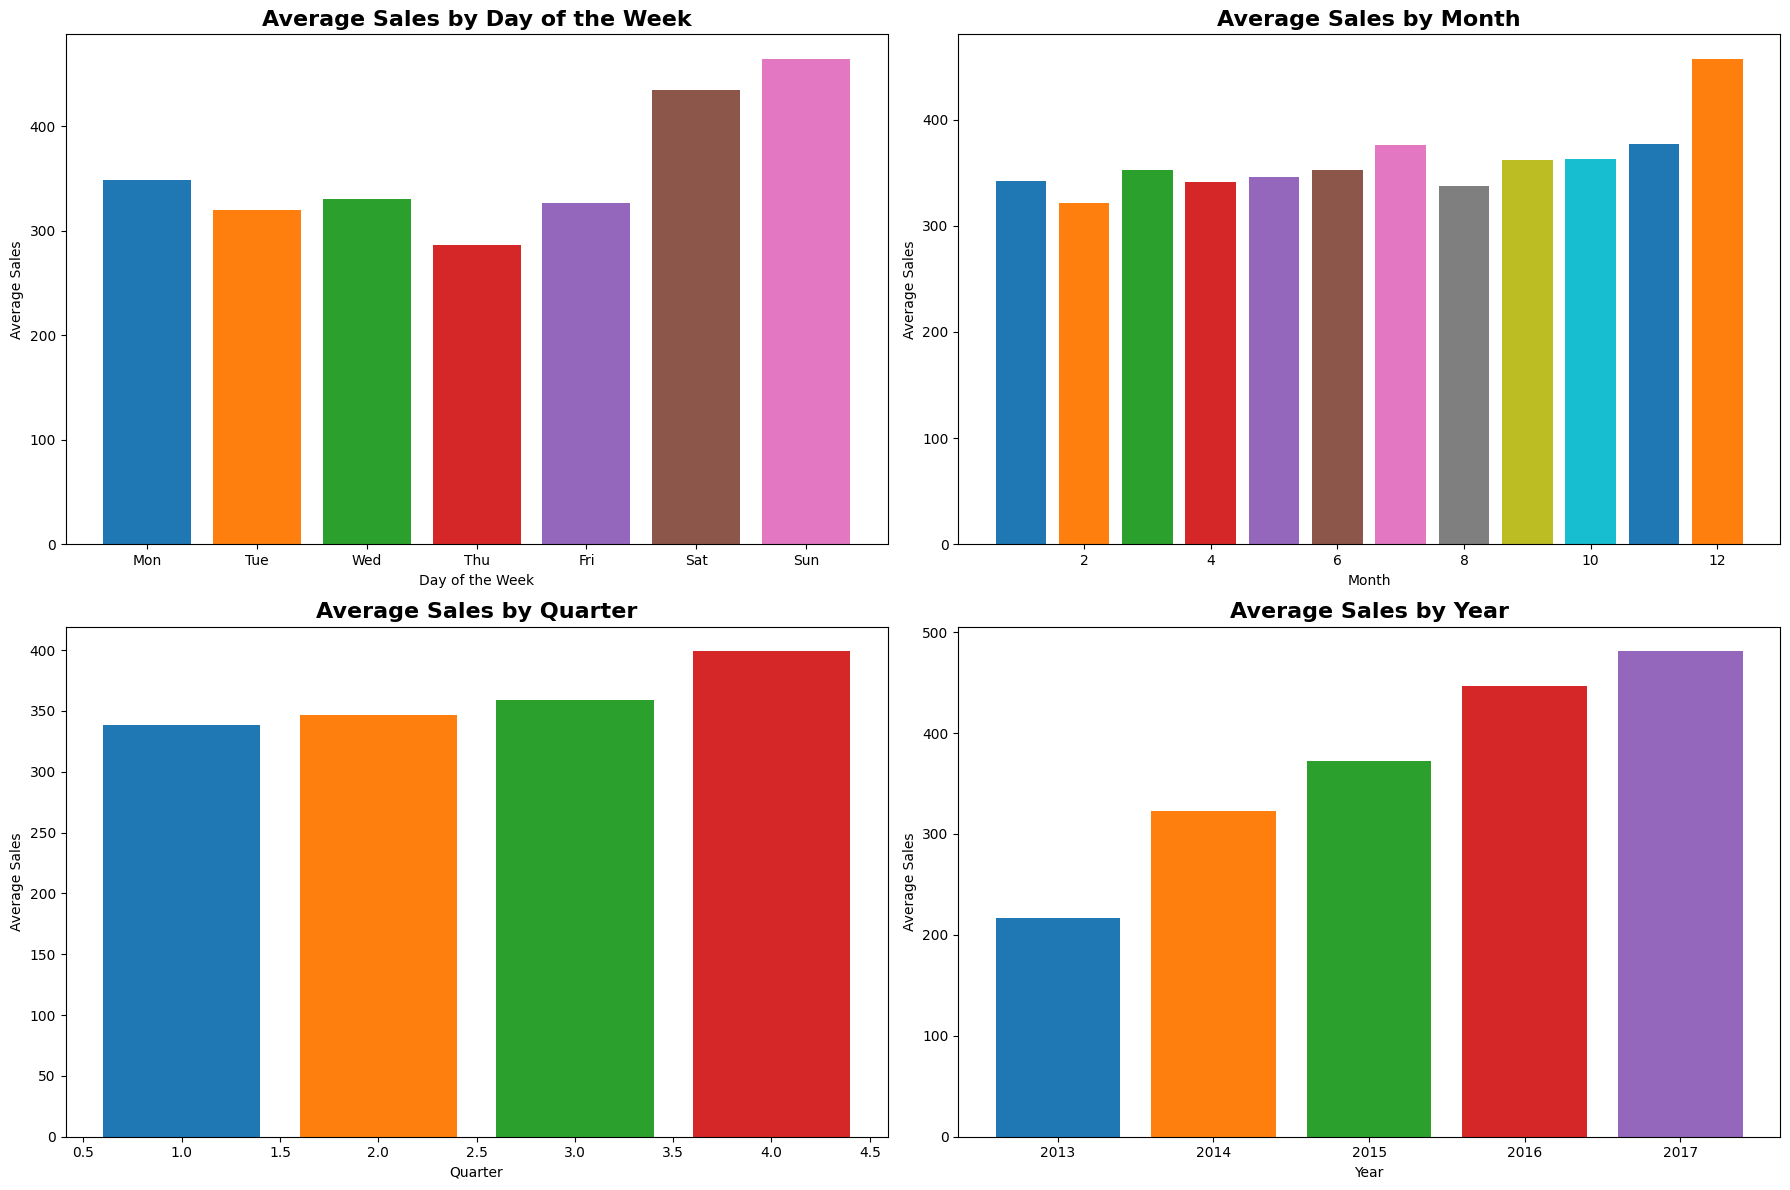

In [45]:
# Extracting date features
train_merged['quarter'] = train_merged['date'].dt.quarter
train_merged['is_weekend'] = train_merged['dayofweek'] >= 5
test_merged['quarter'] = test_merged['date'].dt.quarter
test_merged['is_weekend'] = test_merged['dayofweek'] >= 5

# Calculating average sales by day of the week
sales_by_day_of_week = train_merged.groupby('dayofweek')['sales'].mean()

# Calculating average sales by month
sales_by_month = train_merged.groupby('month')['sales'].mean()

# Calculating average sales by quarter
sales_by_quarter = train_merged.groupby('quarter')['sales'].mean()

# Calculating average sales by year
sales_by_year = train_merged.groupby('year')['sales'].mean()

# Setting up the figure for subplots
fig, axs = plt.subplots(2, 2, figsize=(18, 12))

# Plotting average sales by day of the week
axs[0, 0].bar(sales_by_day_of_week.index, sales_by_day_of_week, color=palette)
axs[0, 0].set_title('Average Sales by Day of the Week',fontsize=16, weight='bold')
axs[0, 0].set_xlabel('Day of the Week')
axs[0, 0].set_ylabel('Average Sales')
axs[0, 0].set_xticks(range(7))
axs[0, 0].set_xticklabels(['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun'])

# Plotting average sales by month
axs[0, 1].bar(sales_by_month.index, sales_by_month, color=palette)
axs[0, 1].set_title('Average Sales by Month', fontsize=16, weight='bold')
axs[0, 1].set_xlabel('Month')
axs[0, 1].set_ylabel('Average Sales')

# Plotting average sales by quarter
axs[1, 0].bar(sales_by_quarter.index, sales_by_quarter, color=palette)
axs[1, 0].set_title('Average Sales by Quarter', fontsize=16, weight='bold')
axs[1, 0].set_xlabel('Quarter')
axs[1, 0].set_ylabel('Average Sales')

# Plotting average sales by year
axs[1, 1].bar(sales_by_year.index, sales_by_year, color=palette)
axs[1, 1].set_title('Average Sales by Year', fontsize=16, weight='bold')
axs[1, 1].set_xlabel('Year')
axs[1, 1].set_ylabel('Average Sales')


plt.tight_layout()
plt.show()

Average Sales by Day of the Week
- **Saturday and Sunday** have the highest average sales, indicating increased consumer activity during weekends.
- **Thursday** shows the lowest average sales among the days of the week, suggesting a mid-week dip in sales.
- Sales are relatively steady from Monday to Wednesday and pick up significantly on Friday, leading into the weekend.

 Average Sales by Month
- **December** has the highest average sales, likely due to holiday shopping and end-of-year activities.
- **January** and **February** have relatively lower sales, which might be due to post-holiday effects and the start of the new year.
- The middle months show consistent sales with slight variations, indicating steady consumer activity throughout the year.

 Average Sales by Quarter
- **Q4** shows the highest average sales, driven by the holiday season and increased consumer spending in the final months of the year.
- The other quarters (Q1, Q2, Q3) have relatively similar average sales, with no significant fluctuations, indicating stable sales performance across these periods.

 Average Sales by Year
- There is a clear upward trend in average sales from **2013 to 2017**, indicating overall growth in sales performance over these years.
- The most significant increase is observed from **2013 to 2014**, followed by steady growth in subsequent years, suggesting positive business growth and potentially successful marketing or expansion strategies.

#### Key Takeaways
- **Weekend Sales**: The highest sales on weekends highlight the importance of targeting weekend shoppers with promotions and marketing efforts.
- **Seasonal Trends**: December's peak in sales underscores the significance of holiday seasons and the need for strategic planning during this period.
- **Quarterly Analysis**: The strong performance in Q4 suggests focusing on the last quarter for maximizing sales opportunities.
- **Yearly Growth**: The consistent growth year-over-year indicates a positive trajectory, with potential for further expansion and increased sales.

### 8. Which product family and stores did the promotions affect.

In [46]:
# Filtering for promotions in the holidays_events data
promotion_days = holidays_events[holidays_events['type']== 'Event']['date']

# Adding a column in the train and test data to indicate if a day is a promotion day
train_merged['is_promotion'] = train_merged['date'].isin(promotion_days)
test_merged['is_promotion'] = test_merged['date'].isin(promotion_days)

In [47]:
# Calculating sales during promotion and non-promotion periods
sales_during_promotion = train_merged[train_merged['is_promotion']]['sales'].mean()
sales_non_promotion = train_merged[~train_merged['is_promotion']]['sales'].mean()

print(f"Average sales during promotions: {sales_during_promotion}")
print(f"Average sales during non-promotion periods: {sales_non_promotion}")

Average sales during promotions: 419.798198092248
Average sales during non-promotion periods: 356.66346947938143


In [48]:
# Aggregating sales by product family
product_family_sales = pd.DataFrame(train_merged.groupby(['family', 'is_promotion'])['sales'].mean().unstack())
      
# Calculating the difference between promotion and non-promotion periods
product_family_sales['difference'] = product_family_sales[True] - product_family_sales[False]

# Filtering top 5 product families based on sales difference
top_5_product_families = product_family_sales.nlargest(5, 'difference')
top_5_product_families

is_promotion,False,True,difference
family,,,
GROCERY I,3762.408127,4512.943840,750.535713
BEVERAGES,2373.729371,2941.045428,567.316057
PRODUCE,1341.353099,1716.842286,375.489187
DAIRY,707.221077,813.138600,105.917522
HOME CARE,174.330965,253.655382,79.324417


In [49]:
# Aggregate sales by store
store_sales = pd.DataFrame(train_merged.groupby(['store_nbr', 'is_promotion'])['sales'].mean().unstack())

# Calculating the difference between promotion and non-promotion periods
store_sales['difference'] = store_sales[True] - store_sales[False]

# Filtering top 5 product families based on sales difference
top_5_product_families = store_sales.nlargest(5, 'difference')
top_5_product_families

is_promotion,False,True,difference
store_nbr,,,
20,228.666999,440.241021,211.574021
45,977.156804,1175.584304,198.427500
2,382.630921,564.691407,182.060486
44,1113.685523,1285.966149,172.280626
53,198.122162,366.454596,168.332434


### 9. What is the difference between RMSLE, RMSE, MSE (or why is the MAE greater than all of them?)

#### a. Mean Squared Error (MSE)
- **Definition**: The Mean Squared Error is the average of the squared differences between the predicted and actual values.
- **Properties**: 
  - It penalizes larger errors more than smaller ones due to the squaring of errors.
  - Sensitive to outliers because squaring magnifies large errors.

#### b. Root Mean Squared Error (RMSE)
- **Definition**: The Root Mean Squared Error is the square root of the Mean Squared Error.
- **Properties**:
  - It has the same units as the target variable.
  - Like MSE, it penalizes larger errors more due to squaring before averaging.

#### c. Root Mean Squared Logarithmic Error (RMSLE)
- **Definition**: The Root Mean Squared Logarithmic Error measures the ratio between the actual and predicted values by comparing the logarithms of the predicted and actual values.
- **Properties**:
  - Useful when the target variable has exponential growth or when the relative error is more important than the absolute error.
  - Less sensitive to large differences for high target values.

#### d. Mean Absolute Error (MAE)
- **Definition**: The Mean Absolute Error is the average of the absolute differences between the predicted and actual values.
- **Properties**:
  - It has the same units as the target variable.
  - It treats all errors equally, without squaring them.
  - Less sensitive to outliers compared to MSE and RMSE.

#### Why is MAE Often Greater than RMSLE, RMSE, and MSE?

The MAE can be greater than RMSLE, RMSE, and MSE for the following reasons:

a. **Penalization of Errors**:
   - MSE and RMSE penalize larger errors more than smaller ones because of the squaring operation. This can lead to a lower overall average error when large errors are infrequent.
   - RMSLE focuses on the logarithmic difference, which means it is less sensitive to large absolute errors but more sensitive to relative differences, particularly when the true values are small.

b. **Error Aggregation**:
   - MAE aggregates errors linearly. It does not give extra weight to larger errors.
   - In contrast, RMSE and MSE give extra weight to larger errors due to the squaring of the errors, which can reduce the impact of smaller errors on the overall metric.

c. **Error Scale**:
   - RMSLE takes the logarithm of the predicted and actual values, which scales down the impact of larger values. Therefore, the logarithmic transformation tends to reduce the magnitude of the errors before squaring and averaging.

- **`MAE`** is often higher because it considers the absolute error without additional penalization.
- **`MSE`** and **`RMSE`** can be lower when large errors are infrequent because they square the errors, reducing the impact of smaller errors.
- **`RMSLE`** can be much lower if the absolute differences are not large relative to the true values because it works with the logarithmic scale. 

### 10. Does the payment of wages in the public sector on the 15th and last days of the month influence the store sales.

In [50]:
# Remove]ing any rows with missing or infinite sales values
train_merged =train_merged[np.isfinite(train_merged['sales'])]

In [51]:
train_merged['is_15th'] = train_merged['day'] == 15
train_merged['is_last_day'] = train_merged['date'] == (train_merged['date'] + pd.offsets.MonthEnd(0))
test_merged['is_15th'] = test_merged['day'] == 15
test_merged['is_last_day'] = test_merged['date'] == (test_merged['date'] + pd.offsets.MonthEnd(0))

# Creating a column to identify if it's either the 15th or the last day
train_merged['is_payday'] = train_merged['is_15th'] | train_merged['is_last_day']
test_merged['is_payday'] = test_merged['is_15th'] | train_merged['is_last_day']

In [52]:
# Calculating average sales
avg_sales_15th = train_merged[train_merged['is_15th']]['sales'].mean()
avg_sales_last_day = train_merged[train_merged['is_last_day']]['sales'].mean()
avg_sales_payday = train_merged[train_merged['is_payday']]['sales'].mean()
avg_sales_other_days = train_merged[~train_merged['is_payday']]['sales'].mean()

print(f"Average sales on 15th: {avg_sales_15th}")
print(f"Average sales on last day of the month: {avg_sales_last_day}")
print(f"Average sales on paydays (15th and last day): {avg_sales_payday}")
print(f"Average sales on other days: {avg_sales_other_days}")

Average sales on 15th: 348.73670744734346
Average sales on last day of the month: 376.50322189431483
Average sales on paydays (15th and last day): 362.49489028142847
Average sales on other days: 358.78033468349633


In [53]:
# Sales on paydays
sales_payday = train_merged[train_merged['is_payday']]['sales']

# Sales on other days
sales_other_days = train_merged[~train_merged['is_payday']]['sales']

# Conducting t-test
t_stat, p_value = ttest_ind(sales_payday, sales_other_days)

print(f"T-statistic: {t_stat}")
print(f"P-value: {p_value}")

if p_value < 0.05:
    print("We Reject the null hypothesis: Public sector wage payments on the 15th and the last days of the month influence store sales.")
else:
    print("We Fail to reject the null hypothesis: Public sector wage payments on the 15th and the last days of the month do not influence store sales.")

T-statistic: 1.4428589010704627
P-value: 0.14906032526483284
We Fail to reject the null hypothesis: Public sector wage payments on the 15th and the last days of the month do not influence store sales.


## **Modeling and Evaluation** 

#### Stationarity Check

In [54]:
# Aggregating sales by date
sales_by_date = train_merged.groupby('date')['sales'].sum()

# Performing Augmented Dickey-Fuller test
adf_result = adfuller(sales_by_date)

# Extracting the p-value from the test
adf_p_value = adf_result[1]

adf_p_value

0.04178984005432057

- The null hypothesis (H0) of the ADF test states that the time series is non-stationary.
- Since the p-value is less than 0.05, we can reject the null hypothesis at the 5% significance level.
- Therefore, the sales data can be considered stationary, meaning its statistical properties such as mean and variance are constant over time.

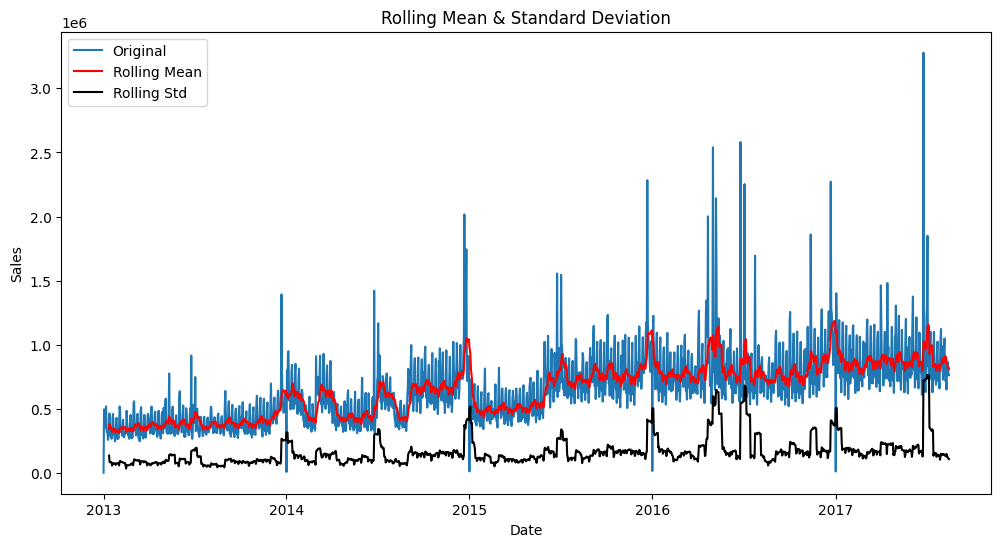

In [55]:
# Computing rolling mean and variance
rolling_mean = sales_by_date.rolling(window=12).mean()
rolling_std = sales_by_date.rolling(window=12).std()

# Plotting rolling statistics
plt.figure(figsize=(12, 6))
plt.plot(sales_by_date, label='Original')
plt.plot(rolling_mean, color='red', label='Rolling Mean')
plt.plot(rolling_std, color='black', label='Rolling Std')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.title('Rolling Mean & Standard Deviation')
plt.legend()
plt.show()

Rolling Mean and Standard Deviation
1. **Seasonal Trends**:
   - There are noticeable spikes at regular intervals, suggesting a strong seasonal component in the sales data.
   - These spikes are especially pronounced during the end-of-year holiday season, indicating higher sales during this period.

2. **Rolling Mean (Red Line)**:
   - The rolling mean shows a gradual upward trend, indicating a general increase in sales over the observed period.
   - Despite the seasonal spikes, the overall trend remains upward, suggesting sustained growth in sales.

3. **Rolling Standard Deviation (Black Line)**:
   - The rolling standard deviation appears relatively stable with minor fluctuations, indicating that the variability in sales is consistent over time.
   - There are a few periods where the standard deviation spikes, likely corresponding to the high-sales seasons.


#### Transformation and Differencing

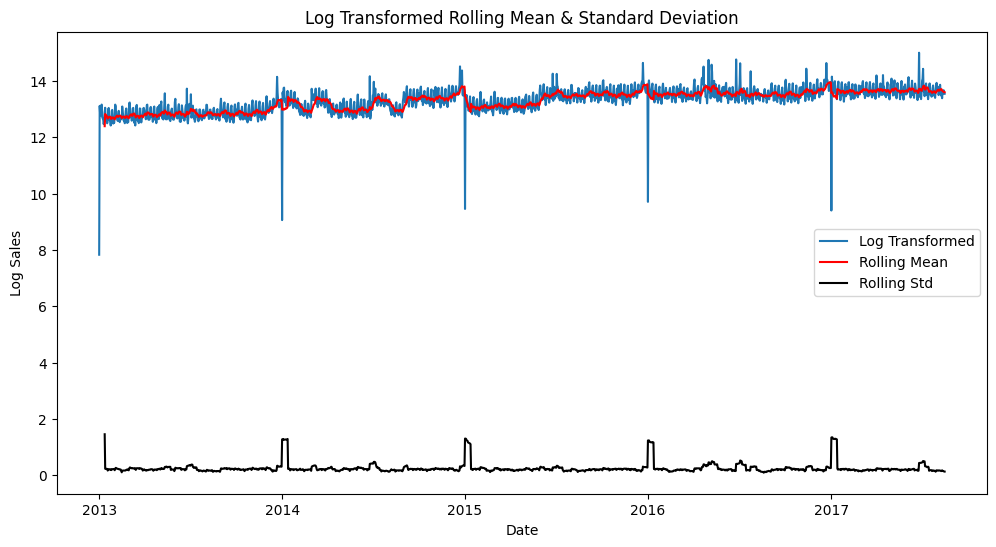

In [56]:
# Applying log transformation
sales_log = np.log(sales_by_date + 1)

# Computing rolling mean and variance on log-transformed data
rolling_mean_log = sales_log.rolling(window=12).mean()
rolling_std_log = sales_log.rolling(window=12).std()

# Plotting rolling statistics on log-transformed data
plt.figure(figsize=(12, 6))
plt.plot(sales_log, label='Log Transformed')
plt.plot(rolling_mean_log, color='red', label='Rolling Mean')
plt.plot(rolling_std_log, color='black', label='Rolling Std')
plt.xlabel('Date')
plt.ylabel('Log Sales')
plt.title('Log Transformed Rolling Mean & Standard Deviation')
plt.legend()
plt.show()

- The log transformation has stabilized the variance, making the data more homoscedastic (i.e., having constant variance).
- Seasonal patterns are still present but are less pronounced, which is beneficial for time series analysis.
- The rolling mean and standard deviation are more stable, indicating a more consistent trend and variability over time.

In [57]:
# Applying differencing
sales_diff = sales_log.diff().dropna()

# Performing ADF test on differenced data
adf_result_diff = adfuller(sales_diff)
adf_p_value_diff = adf_result_diff[1]

adf_p_value_diff

6.554402175657585e-28

- The null hypothesis (H0) of the ADF test states that the time series is non-stationary.
- Since the p-value is significantly less than 0.05, we can reject the null hypothesis at the 5% significance level.
- Therefore, the differenced log-transformed sales data is stationary, meaning its statistical properties such as mean and variance are constant over time.


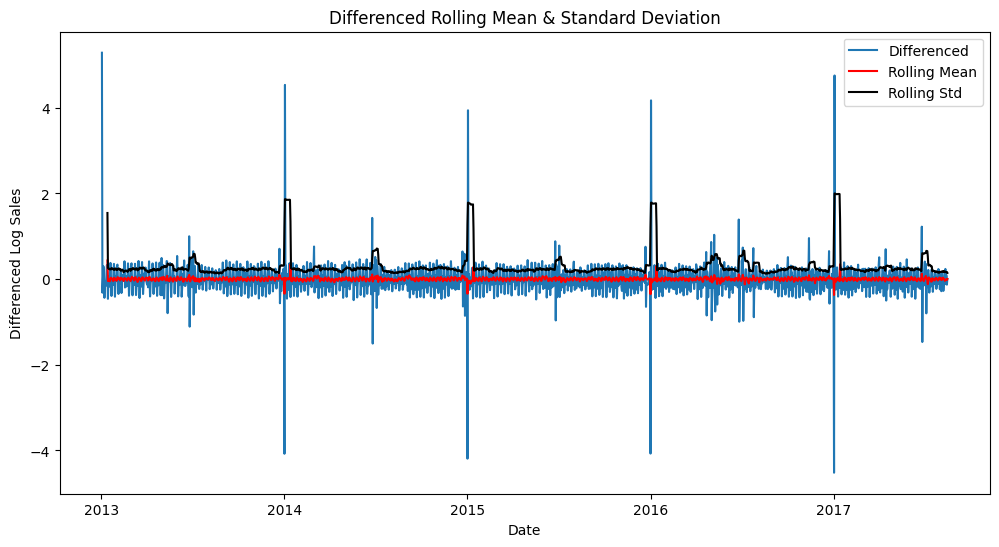

In [58]:
# Computing rolling mean and variance on differenced data
rolling_mean_diff = sales_diff.rolling(window=12).mean()
rolling_std_diff = sales_diff.rolling(window=12).std()

# Plotting rolling statistics on differenced data
plt.figure(figsize=(12, 6))
plt.plot(sales_diff, label='Differenced')
plt.plot(rolling_mean_diff, color='red', label='Rolling Mean')
plt.plot(rolling_std_diff, color='black', label='Rolling Std')
plt.xlabel('Date')
plt.ylabel('Differenced Log Sales')
plt.title('Differenced Rolling Mean & Standard Deviation')
plt.legend()
plt.show()

1. **Differencing**:
   - Differencing the log-transformed data helps remove any trend component, making the series more stationary.
   - This technique is useful for eliminating non-stationarity due to trends and is often a prerequisite for certain time series models like ARIMA.

2. **Seasonal Trends**:
   - After differencing, the seasonal spikes are still present but are further minimized.
   - This indicates that while differencing removes trend components, seasonal effects may still need to be addressed separately.

3. **Rolling Mean (Red Line)**:
   - The rolling mean of the differenced series is very close to zero, indicating that the differencing has effectively removed any long-term trend.
   - The stability of the rolling mean suggests the data is now more suitable for time series modeling.

4. **Rolling Standard Deviation (Black Line)**:
   - The rolling standard deviation is more consistent and less volatile compared to the original and log-transformed data.
   - The consistency in standard deviation implies a more stable variance, which is ideal for modeling purposes.


#### Model Selection and Training

In [59]:
# Setting up the preprocessing steps
categorical_columns = ['store_type', 'city', 'state', 'family']
preprocessor = ColumnTransformer(
    transformers=[
        ('num', SimpleImputer(strategy='mean'), ['onpromotion', 'transactions']),
        ('cat', OneHotEncoder(), categorical_columns)
    ],
    remainder='drop'
)
sparse_scaler = StandardScaler(with_mean=False)
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('scaler', sparse_scaler)
])

# Preparing the data
X = train_merged.drop(columns=['id', 'sales'])
y = train_merged['sales']

# Splitting data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Transforming the data using the pipeline
X_train = pipeline.fit_transform(X_train)
X_test = pipeline.transform(X_test)

# Shapes of the transformed data sets
X_train.shape, X_test.shape, y_train.shape, y_test.shape


((2443478, 78), (610870, 78), (2443478,), (610870,))

Training DecisionTree...
Evaluation Results for DecisionTree:
MAE: 215.9027847957568
MSE: 259036.02145765573
RMSE: 508.9558148382389
RMSLE: 3.0217879530619776


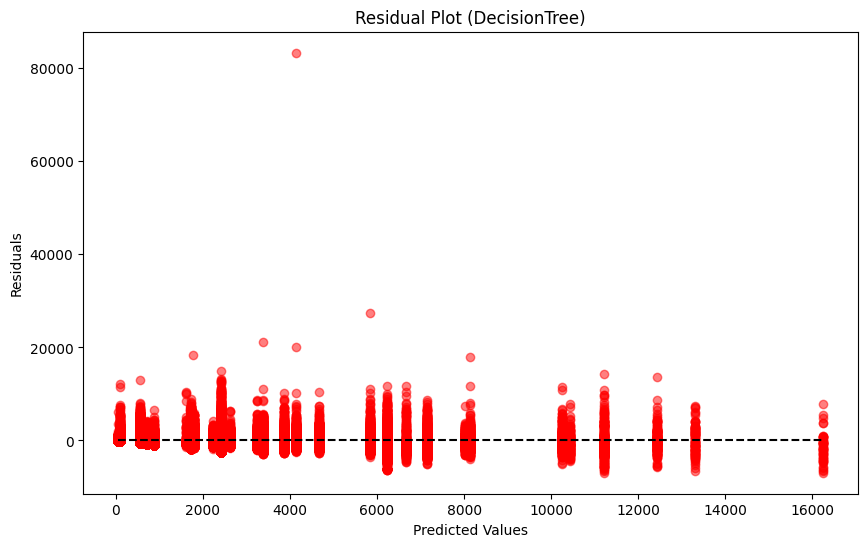

Training RidgeRegression...
Evaluation Results for RidgeRegression:
MAE: 299.6702547247481
MSE: 491984.7117796513
RMSE: 701.4162186459986
RMSLE: 3.3013172173596663


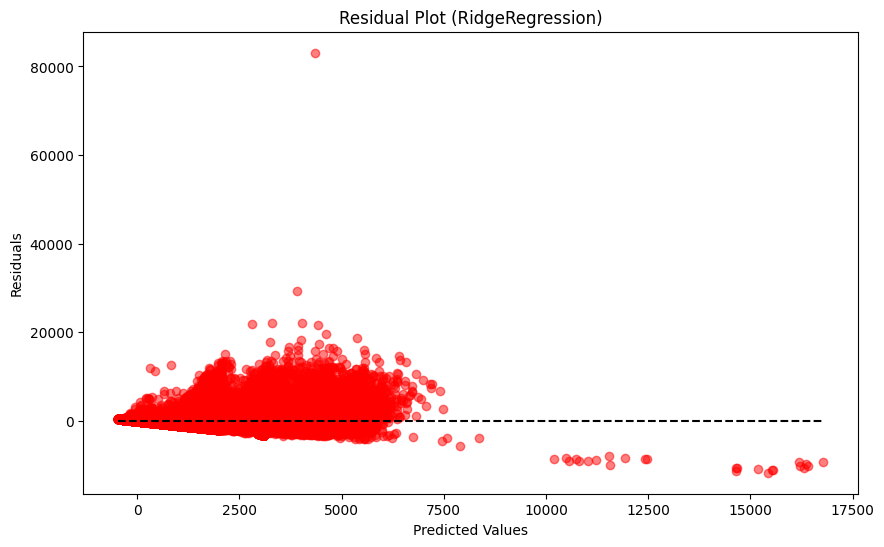

Training LinearRegression...
Evaluation Results for LinearRegression:
MAE: 299.6715752909589
MSE: 491985.2697642202
RMSE: 701.4166164015651
RMSLE: 3.301325091389283


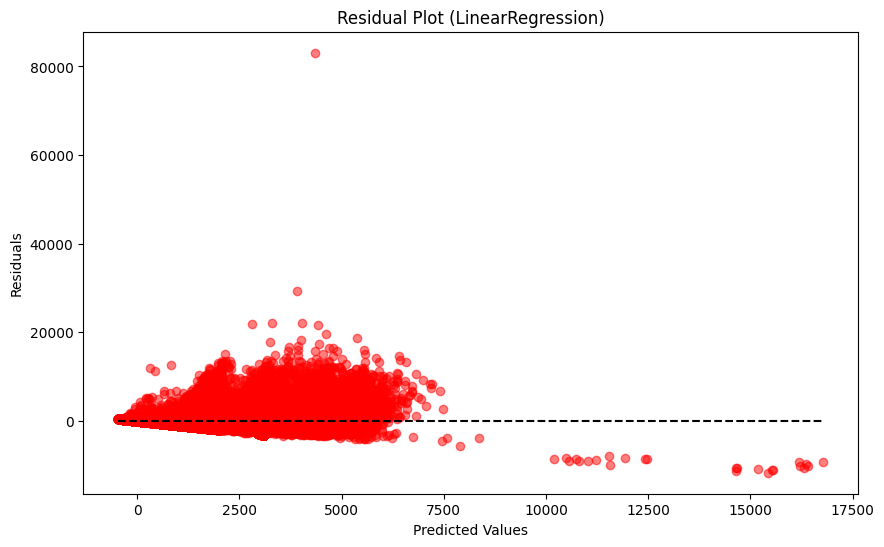

Training XGBoost...
Evaluation Results for XGBoost:
MAE: 99.25215645345592
MSE: 139806.6711678888
RMSE: 373.9073029079384
RMSLE: 1.5807303947510136


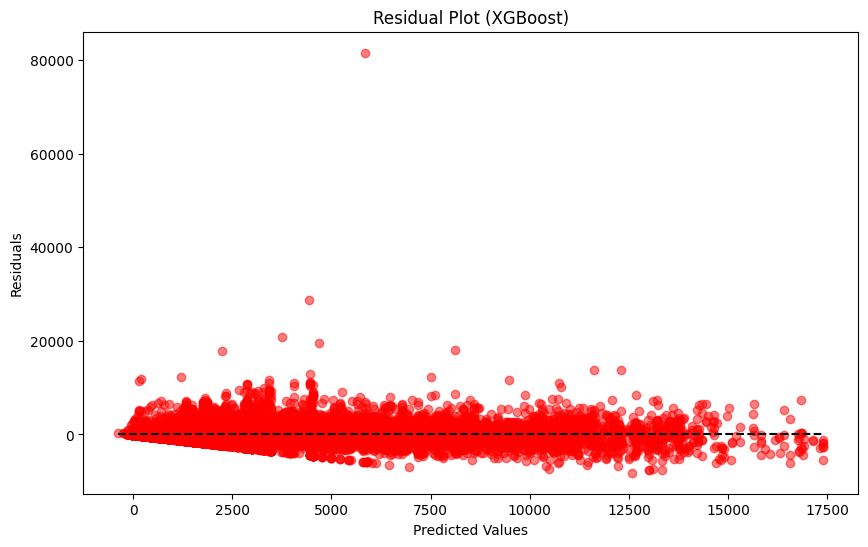

In [60]:
# Function to calculate RMSE
def root_mean_squared_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

# Function to calculate RMSLE
def root_mean_squared_log_error(y_true, y_pred):
    return np.sqrt(mean_squared_error(np.log1p(y_true), np.log1p(y_pred)))


# Configuring Matplotlib to handle more complex paths
mpl.rcParams['agg.path.chunksize'] = 10000
mpl.rcParams['path.simplify'] = True
mpl.rcParams['path.simplify_threshold'] = 0.1

# Initializing models with optimized configurations
models = {
    'DecisionTree': DecisionTreeRegressor(max_depth=5, random_state=42),
    'RidgeRegression': Ridge(alpha=1.0),
    'LinearRegression': LinearRegression(),
    'XGBoost': XGBRegressor(n_estimators=100, random_state=42)
}

# Function to train and evaluate a model
def train_and_evaluate(model, model_name, X_train, y_train, X_test, y_test):
    print(f'Training {model_name}...')
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)

    # Calculating metrics
    mse = mean_squared_error(y_test, predictions)
    mae = mean_absolute_error(y_test, predictions)
    rmse = root_mean_squared_error(y_test, predictions)
    pred_abs = abs(predictions)  # Absolute value of predictions for RMSLE
    rmsle = root_mean_squared_log_error(y_test, pred_abs)

    # Results
    print(f'Evaluation Results for {model_name}:')
    print(f'MAE: {mae}')
    print(f'MSE: {mse}')
    print(f'RMSE: {rmse}')
    print(f'RMSLE: {rmsle}')

    residuals = y_test - predictions

    plt.figure(figsize=(10, 6))
    plt.scatter(predictions, residuals, alpha=0.5, color='red')
    plt.title(f'Residual Plot ({model_name})')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.hlines(y=0, xmin=predictions.min(), xmax=predictions.max(), colors='black', linestyles='--')
    plt.show()



# Training and evaluating each model
for model_name, model in models.items():
    train_and_evaluate(model, model_name, X_train, y_train, X_test, y_test)

##### DecisionTree Model 
**Training DecisionTree...**
- **Mean Absolute Error (MAE):** 215.90
- **Mean Squared Error (MSE):** 259,036.02
- **Root Mean Squared Error (RMSE):** 508.96
- **Root Mean Squared Logarithmic Error (RMSLE):** 3.02

The DecisionTree model shows a moderate MAE and MSE, indicating some error in predictions. The RMSE is relatively high, and the RMSLE suggests significant error in logarithmic terms.

#### RidgeRegression Model 
**Training RidgeRegression...**
- **Mean Absolute Error (MAE):** 299.67
- **Mean Squared Error (MSE):** 491,984.71
- **Root Mean Squared Error (RMSE):** 701.42
- **Root Mean Squared Logarithmic Error (RMSLE):** 3.30

The RidgeRegression model performs worse than the DecisionTree, with higher MAE, MSE, RMSE, and RMSLE, indicating higher prediction errors and less accuracy.

#### LinearRegression Model 
**Training LinearRegression...**
- **Mean Absolute Error (MAE):** 299.67
- **Mean Squared Error (MSE):** 491,985.27
- **Root Mean Squared Error (RMSE):** 701.42
- **Root Mean Squared Logarithmic Error (RMSLE):** 3.30

The LinearRegression model shows almost identical results to RidgeRegression, with similarly high errors across all metrics, indicating poor performance in this scenario.

#### XGBoost Model 
**Training XGBoost...**
- **Mean Absolute Error (MAE):** 99.25
- **Mean Squared Error (MSE):** 139,806.67
- **Root Mean Squared Error (RMSE):** 373.91
- **Root Mean Squared Logarithmic Error (RMSLE):** 1.58

The XGBoost model outperforms all other models significantly, with the lowest MAE, MSE, RMSE, and RMSLE, indicating better accuracy and prediction quality.

#### Residual Analysis 
The residual plots show the distribution of residuals (errors) versus predicted values for each model:

1. **LinearRegression and RidgeRegression:** Both show similar patterns with a higher spread of residuals, indicating more prediction errors and less precision.
2. **XGBoost:** Displays a more concentrated residual distribution around zero, indicating higher accuracy and less error in predictions.
3. **DecisionTree:** Shows a varied spread of residuals, with some high errors, but generally performs better than Linear and RidgeRegression.

#### Conclusion 
- **XGBoost** demonstrates the best performance with the lowest errors across all evaluation metrics, suggesting it is the most accurate model for this dataset.
- **DecisionTree** performs moderately well, better than Linear and RidgeRegression models.
- **RidgeRegression and LinearRegression** exhibit similar and less desirable performance, indicating higher prediction errors and less suitability for this dataset.


## **Saving**

In [61]:
# Defining the full pipeline
full_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('scaler', sparse_scaler),
    ('regressor', models['XGBoost'])
])

# Saving the entire pipeline including the preprocessor and model
joblib.dump(full_pipeline, 'Exports/full_pipeline_xgb.pkl')
print("Pipeline including XGBoost model saved successfully!")

Pipeline including XGBoost model saved successfully!


## **Predictions**


In [62]:
# Load the saved pipeline
full_pipeline = joblib.load('Exports/full_pipeline_xgb.pkl')

# Predict using the loaded pipeline
predictions = full_pipeline.predict(test_merged)

prediction_df = pd.DataFrame({
    'predicted_sales': predictions
})

# Displaying the prediction DataFrame
prediction_df.head()

,predicted_sales
0,-4.320882
1,0.329492
2,764.517639
3,5933.796875
4,-2.727875
